# Investigating AirBNB NYC prices in 2019

## Part 1: Importing and cleaning the dataset

I'll begin by importing some relevant modules which I'll use throughout this work. I've retroactively gone through and added `import` commands to this cell when needed:

In [1]:
## import relevant modules

# Number manipulation and dataframe support
import numpy as np 
import pandas as pd

# Statistical testing
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import kruskal
from scipy.stats import mannwhitneyu
import scikit_posthocs as sph
from sklearn.linear_model import LinearRegression

# Plotting
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.lines as mlines
from matplotlib.lines import Line2D
import seaborn as sns

# This outputs actual text in pdfs
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Geospatial analysis
from shapely import wkt
from shapely.geometry import Point, LineString, Polygon
import geopandas as gpd

# Tools for figure insets
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

# Plot figures in jupyter notebook
%matplotlib inline

# Suppress scientific notation in pd output
pd.options.display.float_format = '{:.2f}'.format

Let's import the data and begin examining it:

In [2]:
# read in csv using pandas
df = pd.read_csv('./data/AB_NYC_2019.csv')

print(f'This dataset contains {df.shape[0]} lines and {df.shape[1]} columns.')

This dataset contains 48895 lines and 16 columns.


In [3]:
df.sample(5, random_state = 1234)

id                                              name   host_id  \
36514  29034190                            The  NYC Getaway Space   9808458   
48599  36334813           Sunny Room in the heart of Williamsburg  17379828   
34181  27110361                     Artist's home in Williamsburg   8731758   
21356  17013882  Big bedroom in Astoria, 20 min from Central Park   7039858   
4887    3493833    Huge Artist Loft with BBQ deck -  WILLIAMSBURG  17592620   

      host_name neighbourhood_group neighbourhood  latitude  longitude  \
36514      Zain               Bronx   Kingsbridge     40.87     -73.90   
48599  Caterina            Brooklyn  Williamsburg     40.71     -73.96   
34181    Jeanne            Brooklyn  Williamsburg     40.71     -73.96   
21356    Costas              Queens       Astoria     40.77     -73.93   
4887       Paul            Brooklyn  Williamsburg     40.72     -73.96   

             room_type  price  minimum_nights  number_of_reviews last_review  \
36514     Private room     65               2                  0         NaN   
48599     Private room     75               3                  0         NaN   
34181  Entire home/apt    175               5                  5  2019-05-23   
21356     Private room     65               3                 23  2018-12-31   
4887   Entire home/apt    318               5                 19  2019-06-01   

       reviews_per_month  calculated_host_listings_count  availability_365  
36514                nan                               4               364  
48599                nan                               1                 7  
34181               0.46                               1               198  
21356               0.81                               1                23  
4887                0.32                               1               268

From looking at the imported dataframe above, we can see each line represents a listing on AirBNB in NYC for 2019. The original uploader has provided descriptions of the different column variables, which I have copied here for convenience:

* `id` : listing ID,
* `name` : name of the listing,
* `host_id` : host ID,
* `host_name` : name of the host,
* `neighbourhood_group` : location [this is the borough],
* `neighbourhood` : area [this is the neighbourhood],
* `latitude` : latitude coordinates,
* `longitude` : longitude coordinates,
* `room_type` : listing space type,
* `price` : price in dollars,
* `minimum_nights` : amount of nights minimum,
* `number_of_reviews` : number of reviews,
* `last_review` : latest review,
* `reviews_per_month` : number of reviews per month,
* `calculated_host_listings_count` : amount of listing per host,
* `availability_365` : number of days when listing is available for booking

In [4]:
# Info about dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
id                                48895 non-null int64
name                              48879 non-null object
host_id                           48895 non-null int64
host_name                         48874 non-null object
neighbourhood_group               48895 non-null object
neighbourhood                     48895 non-null object
latitude                          48895 non-null float64
longitude                         48895 non-null float64
room_type                         48895 non-null object
price                             48895 non-null int64
minimum_nights                    48895 non-null int64
number_of_reviews                 48895 non-null int64
last_review                       38843 non-null object
reviews_per_month                 38843 non-null float64
calculated_host_listings_count    48895 non-null int64
availability_365                  48895 non-null int64

### Duplicated rows

In [5]:
df[df.duplicated()]

Empty DataFrame
Columns: [id, name, host_id, host_name, neighbourhood_group, neighbourhood, latitude, longitude, room_type, price, minimum_nights, number_of_reviews, last_review, reviews_per_month, calculated_host_listings_count, availability_365]
Index: []

No duplicated rows were found so let's move on to missing values.

### Missing values

In [6]:
# Determine how many rows for each variable have missing values
df.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

This reveals there are ~ 10k rows with missing values for `last_review` and `reviews_per_month`. Let's look at some  listings with and without missing values to see if there's a way to to figure out what's going on.

In [7]:
# Sample reviews with missing data in last_review 
df[df.last_review.isnull()].sample(5, random_state = 1234)

id                                               name    host_id  \
39745  30928769                                        Cozy Room B  213781715   
19295  15377407   MAGNIFICIENT LUX. STUDIO UNOBSTRUCTED RIVER VIEW   98267290   
45949  35005637  Sonder | Upper East Side | Stylish 1BR + Sofa Bed  219517861   
37782  29923677                Shop 5th Ave + Explore Central Park  220229838   
44733  34383611   Spacious Room in a charming brownstone apartment     877452   

           host_name neighbourhood_group    neighbourhood  latitude  \
39745         Anting            Brooklyn       Greenpoint     40.73   
19295        Heather           Manhattan  Upper West Side     40.78   
45949   Sonder (NYC)           Manhattan  Upper East Side     40.76   
37782  Chamber Hotel           Manhattan          Midtown     40.76   
44733        Rebecca            Brooklyn       Park Slope     40.68   

       longitude        room_type  price  minimum_nights  number_of_reviews  \
39745     -73.95     Private room     89               1                  0   
19295     -73.98  Entire home/apt    130              30                  0   
45949     -73.96  Entire home/apt    160              29                  0   
37782     -73.98     Private room    233               2                  0   
44733     -73.98     Private room     95               5                  0   

      last_review  reviews_per_month  calculated_host_listings_count  \
39745         NaN                nan                              33   
19295         NaN                nan                               1   
45949         NaN                nan                             327   
37782         NaN                nan                              11   
44733         NaN                nan                               1   

       availability_365  
39745               180  
19295               185  
45949               311  
37782               163  
44733                 0

In [8]:
# Reviews with data in last_review
df[df.last_review.notnull()].sample(5, random_state = 1234)

id                                               name    host_id  \
32413  25374003  Spacious room brand new.Beautiful yard also av...  191577969   
4354    2927005                Charming 2 Bedroom by Prospect Park      17930   
2819    1578721                        Huge, Sunny Greenpoint Flat     999689   
25668  20555569             Rooming has never been better. Room #2   95572265   
39707  30908416  Sunny Greenpoint Apartment 5 Min Walk To Nassau G   25812202   

      host_name neighbourhood_group       neighbourhood  latitude  longitude  \
32413   Nikolas              Queens    Ditmars Steinway     40.78     -73.92   
4354      Seryn            Brooklyn     Windsor Terrace     40.66     -73.98   
2819       Eric            Brooklyn          Greenpoint     40.73     -73.95   
25668     Laura            Brooklyn  Bedford-Stuyvesant     40.68     -73.93   
39707      Leah            Brooklyn          Greenpoint     40.73     -73.95   

             room_type  price  minimum_nights  number_of_reviews last_review  \
32413     Private room    110               2                  5  2018-10-27   
4354   Entire home/apt    200               5                 37  2019-05-27   
2819      Private room     35              30                  5  2014-04-23   
25668     Private room     45               3                  4  2018-07-28   
39707     Private room     45              14                  2  2019-06-25   

       reviews_per_month  calculated_host_listings_count  availability_365  
32413               0.48                               1                90  
4354                0.78                               2                78  
2819                0.07                               1                97  
25668               0.21                               2               342  
39707               0.32                               1                21

I think the key here is the `number_of_reviews` column. Listings with missing values for `last_review` and `reviews_per_month` have 0 reviews. Listings with 1 review or more have values for these two columns. In other words, listings with missing values for `last_review` and `reviews_per_month` don't have any reviews to begin with. Therefore, let's go ahead and fill these rows for `reviews_per_month` with `0`. We don't want to treat `last_review` the same since `NaN` here really means a missing value because there can't be a review.

In [9]:
# Replacing all missing values in 'reviews_per_month'
df.fillna({'reviews_per_month':0}, inplace=True)

In [10]:
# Confirm there are no rows with missing values for 'last_review' and 'reviews_per_month'
df.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                     0
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Now we've dealt with the biggest issue, let's move on to the other variables/columns. As we can see from above, there are 16 and 21 rows with missing values for `name` and `host_name`, respectively. Should we exclude these rows from the dataset?

Let's begin by looking at the rows which don't have values for the `name` column (note: this refers to the listing name rather than the host name):

In [11]:
df[df.name.isnull()].head(5)

id name   host_id host_name neighbourhood_group      neighbourhood  \
2854  1615764  NaN   6676776     Peter           Manhattan  Battery Park City   
3703  2232600  NaN  11395220      Anna           Manhattan       East Village   
5775  4209595  NaN  20700823     Jesse           Manhattan  Greenwich Village   
5975  4370230  NaN  22686810   Michaël           Manhattan             Nolita   
6269  4581788  NaN  21600904     Lucie            Brooklyn       Williamsburg   

      latitude  longitude        room_type  price  minimum_nights  \
2854     40.71     -74.02  Entire home/apt    400            1000   
3703     40.73     -73.99  Entire home/apt    200               1   
5775     40.73     -73.99  Entire home/apt    225               1   
5975     40.72     -74.00  Entire home/apt    215               7   
6269     40.71     -73.94     Private room    150               1   

      number_of_reviews last_review  reviews_per_month  \
2854                  0         NaN               0.00   
3703                 28  2015-06-08               0.45   
5775                  1  2015-01-01               0.02   
5975                  5  2016-01-02               0.09   
6269                  0         NaN               0.00   

      calculated_host_listings_count  availability_365  
2854                               1               362  
3703                               1               341  
5775                               1                 0  
5975                               1                 0  
6269                               1                 0

From looking at the raw data, they appear to be legitimate listings with sensible looking entries and several of them even have reviews. So what's going on here? Could it be an error during data collection? Alternatively, maybe the host does not have a listing name? This seems unusual but we can take one (or several) of the ids and check. For instance, the listing with id 2232600, https://www.airbnb.com/rooms/2232600, reveals the host has chosen not to include a description at the time of writing.

What about listings without a `host_name`? Since I'm not interested in this data, suffice to say this appears to be due to errors in data collection since the listings are real and have host names.

In both cases, I have chosen *not* to delete the rows because most of the data is still useful and it's unlikely we will care about the names of the hosts. We might want to do some sort of analysis on the `name` column (e.g. are words like 'beautiful' associated with higher number of reviews?). If we go down that route, I'll remove those rows then.

### Identification of outliers

Now we've dealt with missing values, let's turn our attention to values that might be outliers and consider their implications. To start with, lets begin by plotting histograms for each variable/column and use pandas `describe()` function to help identify outliers.

Of course some plots will be nonsense; for example `id` and `host_id` are assigned by AirBNB and could very well be random numbers. Additionally we can't examine non-numerical columns with this method (we'll get to those later). 

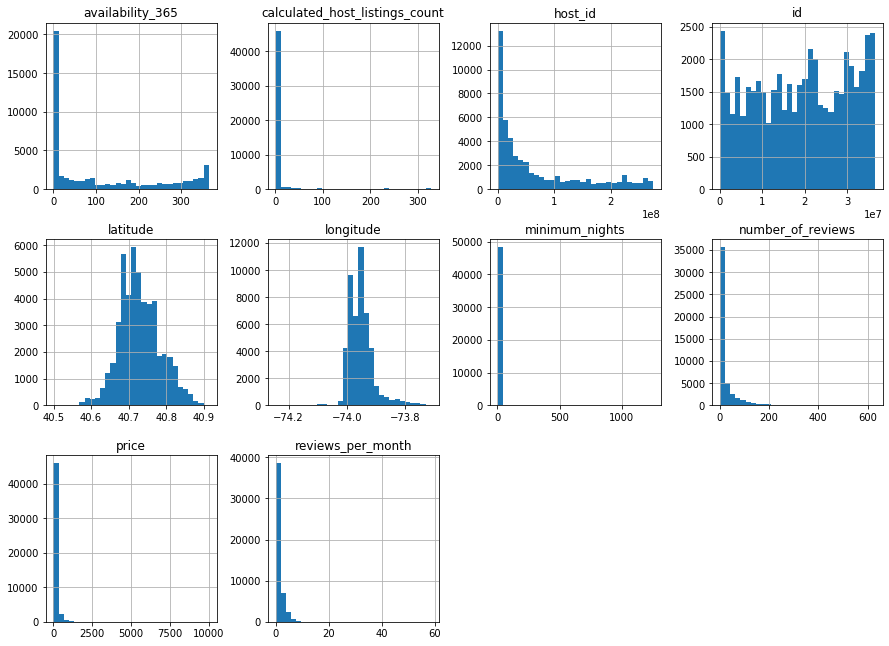

In [12]:
# Plot histograms for variables/columns with numerical values
df.hist(figsize = [15,15], layout = [4, 4], bins = 30);

In [13]:
# Define numeric column types
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
# Select and summarise (describe) numeric columns and transpose:
df.select_dtypes(include=numerics).describe().T

count        mean         std     min  \
id                             48895.00 19017143.24 10983108.39 2539.00   
host_id                        48895.00 67620010.65 78610967.03 2438.00   
latitude                       48895.00       40.73        0.05   40.50   
longitude                      48895.00      -73.95        0.05  -74.24   
price                          48895.00      152.72      240.15    0.00   
minimum_nights                 48895.00        7.03       20.51    1.00   
number_of_reviews              48895.00       23.27       44.55    0.00   
reviews_per_month              48895.00        1.09        1.60    0.00   
calculated_host_listings_count 48895.00        7.14       32.95    1.00   
availability_365               48895.00      112.78      131.62    0.00   

                                      25%         50%          75%  \
id                             9471945.00 19677284.00  29152178.50   
host_id                        7822033.00 30793816.00 107434423.00   
latitude                            40.69       40.72        40.76   
longitude                          -73.98      -73.96       -73.94   
price                               69.00      106.00       175.00   
minimum_nights                       1.00        3.00         5.00   
number_of_reviews                    1.00        5.00        24.00   
reviews_per_month                    0.04        0.37         1.58   
calculated_host_listings_count       1.00        1.00         2.00   
availability_365                     0.00       45.00       227.00   

                                        max  
id                              36487245.00  
host_id                        274321313.00  
latitude                              40.91  
longitude                            -73.71  
price                              10000.00  
minimum_nights                      1250.00  
number_of_reviews                    629.00  
reviews_per_month                     58.50  
calculated_host_listings_count       327.00  
availability_365                     365.00

From top-left to bottom-right:

* `availability_365`: it looks like most properties are available for ~ 0-10 days. There are many properties available for longer periods of time but no obvious erroneous values (e.g. > 365 days, < 0 days).
* `calculated_host_listings_count`: Shockingly it looks like one host has over 300 listings! Definitely dig into this later.
* `host_id`: ignore
* `id`: ignore
* `latitude`: ignore (for now)
* `longitude`: ignore (for now)
* `minimum_nights`: definitely some outliers here, ~ 1 property requires you to reserve 1250 nights...
* `number_of_reviews`: most listings have 0 to ~ 50 reviews. Some with well over 200 reviews! Note to self: stay there.
* `price`: definitely some outliers here. \\$10,000 per night seems a tad excessive whilst \\$0 per night seems a bit too charitable.
* `reviews_per_month`: Is someone gaming the system? How do you get 58.5 reviews in 30/31 days?

#### `calculated_host_listings_count`

The person who uploaded the dataset included a column which counts the number of listings which belong to a particular host (`calculated_host_listings_count`) but since there is no information about how that value was calculated, I'm not sure if I do or want to trust it (particularly since there is allegedly one host with over 300 listings).

Fortunately, we can recalculate the number of listings per host relatively easily by using `value_counts()` (https://stackoverflow.com/questions/22391433/count-the-frequency-that-a-value-occurs-in-a-dataframe-column) which we can apply to the `host_id` column which is unique to each host:

In [14]:
# Find the # of listings for each hosts
all_host_counts = df.host_id.value_counts()
print(f'There are {len(all_host_counts)} unique hosts. The top 15 hosts are:')

# Find 15 most prolific hosts
top_15 = all_host_counts.head(15)
top_15

There are 37457 unique hosts. The top 15 hosts are:


219517861    327
107434423    232
30283594     121
137358866    103
12243051      96
16098958      96
61391963      91
22541573      87
200380610     65
7503643       52
1475015       52
120762452     50
2856748       49
205031545     49
190921808     47
Name: host_id, dtype: int64

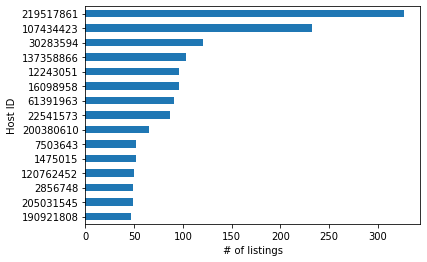

In [15]:
# Plot data
fig = plt.figure()
ax = fig.add_subplot(111)
ax = top_15.plot.barh(y = 'host_id')

ax.set_xlabel('# of listings')
ax.set_ylabel('Host ID');
ax.invert_yaxis();

Somewhat surprisingly these values match with the original dataset which means there is one host with 327 listings. 

Let's take a look at some of those listings: 

In [16]:
# Select sample of rows from df where host_id = 219517861
df[df['host_id'] == 219517861].sample(5, random_state = 1234)

id                                              name    host_id  \
41430  32238462    Sonder | Stock Exchange | Sleek 3BR + Sofa Bed  219517861   
39773  30937596        Sonder | 11th Ave | Contemporary 1BR + Gym  219517861   
44622  34323730         Sonder | 116 John | Comfortable 1BR + Gym  219517861   
41756  32467087    Sonder | The Nash | Lively 1BR + Grilling Area  219517861   
41431  32238473  Sonder | Stock Exchange | Sleek Studio + Kitchen  219517861   

          host_name neighbourhood_group       neighbourhood  latitude  \
41430  Sonder (NYC)           Manhattan  Financial District     40.71   
39773  Sonder (NYC)           Manhattan      Hell's Kitchen     40.76   
44622  Sonder (NYC)           Manhattan  Financial District     40.71   
41756  Sonder (NYC)           Manhattan         Murray Hill     40.75   
41431  Sonder (NYC)           Manhattan  Financial District     40.71   

       longitude        room_type  price  minimum_nights  number_of_reviews  \
41430     -74.01  Entire home/apt    451               2                 15   
39773     -74.00  Entire home/apt    185              29                  1   
44622     -74.01  Entire home/apt    130              29                  0   
41756     -73.97  Entire home/apt    204              29                  0   
41431     -74.01  Entire home/apt    241               2                  5   

      last_review  reviews_per_month  calculated_host_listings_count  \
41430  2019-06-21               4.37                             327   
39773  2019-06-10               1.00                             327   
44622         NaN               0.00                             327   
41756         NaN               0.00                             327   
41431  2019-06-12               1.35                             327   

       availability_365  
41430               254  
39773               332  
44622               337  
41756               158  
41431               284

They look real! Taking a closer look at their [profile](https://www.airbnb.com/users/219517861/listings) reveals they do indeed have many listings and a quick google reveals they're a hotel company (https://www.sonder.com/). Perhaps not in the spirit of AirBNB!

I won't do an exhaustive description of the other hosts with a large number of listings, but the next in the list, `host_id = 107434423` is interesting since they seem to specialise in relatively long stays for AirBNB listings, with no rooms avaialble for less than 30 days:

In [17]:
# For host 107434423, what are the unique entries for minimum number of nights, and how many of each?
df[df['host_id'] == 107434423].minimum_nights.value_counts()

30     224
90       5
120      2
60       1
Name: minimum_nights, dtype: int64

For comparison, this is the breakdown for `host_id = 219517861` (the host with the most listings):

In [18]:
df[df['host_id'] == 219517861].minimum_nights.value_counts()

2     190
29    137
Name: minimum_nights, dtype: int64

I highlight these data because it might be important later on. With so many listings, such hosts might skew our perception of the 'typical' host e.g. is the average minimum number of nights really closer to 30 or do these 'super' hosts skew the # of nights? 

We can see that the typical host lists only 1 property (86 %). 9 % of hosts list 2 properties and only ~ 5 % of hosts have more than 3 properties listed, so these types of host are definitely not typical:

In [19]:
# Find listings per host as percent of total host population
# Take each value_count within our host_id counts, then divide by the sum of all host counts
listing_percent = 100*(all_host_counts.value_counts() / all_host_counts.value_counts().sum())

# Print first five (descending order)
print(listing_percent.head(5))

1   86.24
2    8.89
3    2.54
4    0.96
5    0.45
Name: host_id, dtype: float64


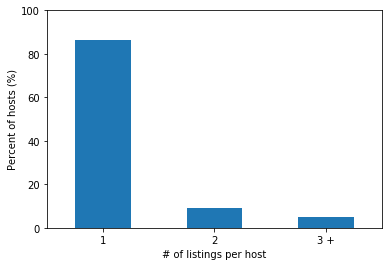

In [20]:
# Sum all percents where there are more than 2 listings per host
# https://stackoverflow.com/questions/39125695/how-to-sum-all-values-with-index-greater-than-x
collated_listing_percent = listing_percent.groupby(np.where(listing_percent.index > 2, '3 +', listing_percent.index)).sum()

# Plot data
fig = plt.figure()
ax = fig.add_subplot(111)
ax = collated_listing_percent.plot.bar()

ax.set_ylim([0,100])
ax.tick_params(axis='x', which='major', rotation=0)
ax.set_xlabel('# of listings per host')
ax.set_ylabel('Percent of hosts (%)');

Since nearly all hosts only list one property, maybe we should split the dataset into two groups? Those with one listing and those with 2 or more? For the sake of (some) brevity, I haven't done this but it might be worth coming back to in future iterations of this analysis.

For now, I'll replace the original `calculated_host_listings_count` with our new values we've just calculated and add another column `more_than_1_listing` which we can use to quickly partition our data later:

In [21]:
# Aim: replace the calculated_host_listings_count in the original df with our new values

# Convert all_host_counts to a df and reset index so we can 'access' host_id
all_host_counts = all_host_counts.to_frame().reset_index()

# rename columns
all_host_counts.columns = ['host_id','count']

# Create a dummy variable to make it easier to split our data later on
all_host_counts.loc[all_host_counts['count'] > 1, 'more_than_1_listing'] = "2 or more listings"
all_host_counts.loc[all_host_counts['count'] == 1, 'more_than_1_listing'] = "1 listing"

# Replace calculated_host_listings_count with values in all_host_counts according to host_id
# NOTE TO SELF: left join by host_id would be cleaner here....
df['calculated_host_listings_count'] = df['host_id'].map(all_host_counts.set_index('host_id')['count'])
df['more_than_1_listing'] = df['host_id'].map(all_host_counts.set_index('host_id')['more_than_1_listing'])

# Confirm the most prolific host has 327 listings labelled in calculated_host_listings_count
df[df['host_id'] == 219517861].sample(1)

id                                               name    host_id  \
45959  35005963  Sonder | Theater District | Bright 1BR + City ...  219517861   

          host_name neighbourhood_group     neighbourhood  latitude  \
45959  Sonder (NYC)           Manhattan  Theater District     40.76   

       longitude        room_type  price  minimum_nights  number_of_reviews  \
45959     -73.99  Entire home/apt    217              29                  0   

      last_review  reviews_per_month  calculated_host_listings_count  \
45959         NaN               0.00                             327   

       availability_365 more_than_1_listing  
45959               357  2 or more listings

### Price

From the above summary stats, we can see there are some listings which are free to rent, but is this really the case?

In [22]:
print(f"There are {df[df['price'] == 0]['price'].count()} listings where the price is 0.")
df[df['price'] == 0].sample(5, random_state = 1234)

There are 11 listings where the price is 0.


id                                               name    host_id  \
26259  20933849                              the best you can find   13709292   
25634  20523843    MARTIAL LOFT 3: REDEMPTION (upstairs, 2nd room)   15787004   
26841  21291569  Coliving in Brooklyn! Modern design / Shared room  101970559   
26866  21304320             Best Coliving space ever! Shared room.  101970559   
25433  20333471      ★Hostel Style Room | Ideal Traveling Buddies★  131697576   

          host_name neighbourhood_group    neighbourhood  latitude  longitude  \
26259        Qiuchi           Manhattan      Murray Hill     40.75     -73.98   
25634  Martial Loft            Brooklyn         Bushwick     40.69     -73.92   
26841        Sergii            Brooklyn         Bushwick     40.69     -73.91   
26866        Sergii            Brooklyn         Bushwick     40.69     -73.91   
25433        Anisha               Bronx  East Morrisania     40.83     -73.89   

             room_type  price  minimum_nights  number_of_reviews last_review  \
26259  Entire home/apt      0               3                  0         NaN   
25634     Private room      0               2                 16  2019-05-18   
26841      Shared room      0              30                  2  2019-06-22   
26866      Shared room      0              30                  5  2019-05-24   
25433     Private room      0               2                 55  2019-06-24   

       reviews_per_month  calculated_host_listings_count  availability_365  \
26259               0.00                               1                 0   
25634               0.71                               5                 0   
26841               0.11                               6               333   
26866               0.26                               6               139   
25433               2.56                               4               127   

      more_than_1_listing  
26259           1 listing  
25634  2 or more listings  
26841  2 or more listings  
26866  2 or more listings  
25433  2 or more listings

So they're real listings but from manually checking the listings on AirBNB, we can see they're, unfortunately, not free. So, I will remove these from the dataset:

In [23]:
# Remove listings where the price is 0
df = df[df['price'] > 0]

# Confirm they're gone
df[df['price'] == 0]

Empty DataFrame
Columns: [id, name, host_id, host_name, neighbourhood_group, neighbourhood, latitude, longitude, room_type, price, minimum_nights, number_of_reviews, last_review, reviews_per_month, calculated_host_listings_count, availability_365, more_than_1_listing]
Index: []

Now let's turn our attention to listings on the other end of the distribution; those which are more than $5k per night:

In [24]:
df[df.price > 5000].sample(5, random_state = 1234)

id                                               name   host_id  \
4377    2953058                                      Film Location   1177497   
37194  29547314               Apartment New York \nHell’s Kitchens  35303743   
3774    2271504                   SUPER BOWL Brooklyn Duplex Apt!!  11598359   
43009  33397385    Midtown Manhattan great location (Gramacy park)  16105313   
40433  31340283  2br - The Heart of NYC: Manhattans Lower East ...   4382127   

      host_name neighbourhood_group    neighbourhood  latitude  longitude  \
4377    Jessica            Brooklyn     Clinton Hill     40.69     -73.97   
37194  Patricia           Manhattan  Upper West Side     40.77     -73.98   
3774   Jonathan            Brooklyn     Clinton Hill     40.69     -73.96   
43009     Debra           Manhattan          Midtown     40.74     -73.98   
40433      Matt           Manhattan  Lower East Side     40.72     -73.99   

             room_type  price  minimum_nights  number_of_reviews last_review  \
4377   Entire home/apt   8000               1                  1  2016-09-15   
37194     Private room   6500              30                  0         NaN   
3774   Entire home/apt   6500               1                  0         NaN   
43009  Entire home/apt   5100              30                  1  2019-06-22   
40433  Entire home/apt   9999              30                  0         NaN   

       reviews_per_month  calculated_host_listings_count  availability_365  \
4377                0.03                              11               365   
37194               0.00                               1                97   
3774                0.00                               1                 0   
43009               1.00                               2               343   
40433               0.00                               1               365   

      more_than_1_listing  
4377   2 or more listings  
37194           1 listing  
3774            1 listing  
43009  2 or more listings  
40433           1 listing

Oddly enough, some properties are listed for the prices found here on AirBNB. In some cases several of the properties are also *not* available for any nights (e.g. third row above), so I'd guess that having a high price and no availability is just an easy way for some of these hosts to keep their listing (and associated reviews?) for future use. Nonetheless, I can't assume why these properties are listed for such high prices or that they're erroneous, so I'm not going to delete them.

### Availability

How many nights a year are listings available to rent?

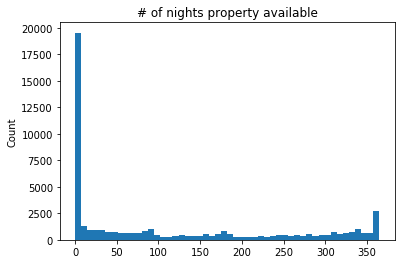

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax = df.availability_365.plot.hist(bins = 50)

ax.set_ylabel('Count')
ax.set(title = "# of nights property available");

In [26]:
df[df.availability_365 == 0]['id'].count() / df['id'].count() * 100

35.860404222240405

36 % of properties are not available to rent at all in 2019. I have not removed them from the proceeding analysis but this might be something we want to do if we want to look at active listings only. 

#### Non-numeric columns

Let's now turn our attention to the columns which are non-numeric. We can select those columns which aren't numeric as follows:

In [27]:
# Of the columns, which are object?
df.select_dtypes(include = ['object']).head()

name    host_name  \
0                Clean & quiet apt home by the park         John   
1                             Skylit Midtown Castle     Jennifer   
2               THE VILLAGE OF HARLEM....NEW YORK !    Elisabeth   
3                   Cozy Entire Floor of Brownstone  LisaRoxanne   
4  Entire Apt: Spacious Studio/Loft by central park        Laura   

  neighbourhood_group neighbourhood        room_type last_review  \
0            Brooklyn    Kensington     Private room  2018-10-19   
1           Manhattan       Midtown  Entire home/apt  2019-05-21   
2           Manhattan        Harlem     Private room         NaN   
3            Brooklyn  Clinton Hill  Entire home/apt  2019-07-05   
4           Manhattan   East Harlem  Entire home/apt  2018-11-19   

  more_than_1_listing  
0  2 or more listings  
1  2 or more listings  
2           1 listing  
3           1 listing  
4           1 listing

So there are 5 columns which describe properties of the listing (excluding the `more_than_1_listing` column I just defined above). However, the second to last column is actually a date, which has a specific dtype. We can use the following to convert this column:

In [28]:
# Convert last_review to date.
df['last_review'] = pd.to_datetime(df['last_review'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48884 entries, 0 to 48894
Data columns (total 17 columns):
id                                48884 non-null int64
name                              48868 non-null object
host_id                           48884 non-null int64
host_name                         48863 non-null object
neighbourhood_group               48884 non-null object
neighbourhood                     48884 non-null object
latitude                          48884 non-null float64
longitude                         48884 non-null float64
room_type                         48884 non-null object
price                             48884 non-null int64
minimum_nights                    48884 non-null int64
number_of_reviews                 48884 non-null int64
last_review                       38833 non-null datetime64[ns]
reviews_per_month                 48884 non-null float64
calculated_host_listings_count    48884 non-null int64
availability_365                  48884 non-nu

Let's now plot the date of review:

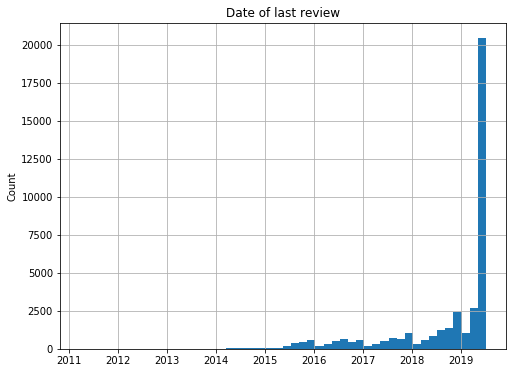

In [29]:
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111)

df.last_review.hist(bins = 50, ax = ax)

ax.set_ylabel('Count')
ax.set(title = "Date of last review");

Yikes, so we can see a lot of properties have not had a review since the end of 2018 or earlier. I wonder if it's the same properties that are not availble to rent? Let's take a look:

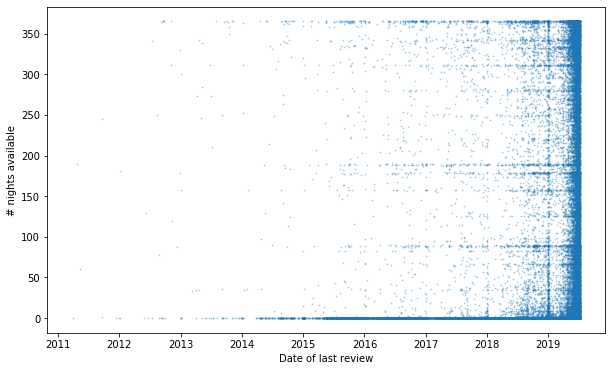

In [30]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)

plt.plot_date(x = df[df.last_review.notnull()].last_review, y = df[df.last_review.notnull()].availability_365, alpha = 0.25, markersize = 1)

ax.set_ylabel('# nights available')
ax.set_xlabel('Date of last review');

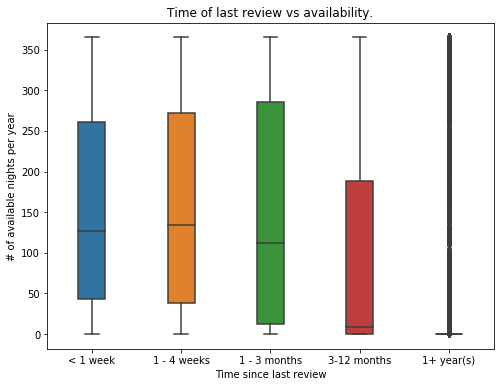

In [31]:
# Find number of days since last review relative to latest review in dataset
df['days_since'] = max(df.last_review) - df.last_review

# Partition data into arbitary groups
cut_labels = ['< 1 week', '1 - 4 weeks', '1 - 3 months', '3-12 months', '1+ year(s)']
cut_bins = [0, 7, 28, 90, 365, 50000]

# Add column to df based on above groups
df['cut_days'] = pd.cut(df.days_since, bins = pd.to_timedelta(cut_bins, unit = 'd'), labels=cut_labels)

# Plot new data
fig = plt.figure(figsize = [8,6])
ax = fig.add_subplot(111)

sns.boxplot(data = df, y = 'availability_365', x = 'cut_days', ax = ax, width = 0.3)

ax.set_title('Time of last review vs availability.')
ax.set_xlabel('Time since last review')
ax.set_ylabel('# of available nights per year');

In [32]:
df.loc[:,('cut_days','availability_365')].groupby('cut_days').describe().T

cut_days                < 1 week  1 - 4 weeks  1 - 3 months  3-12 months  \
availability_365 count   4636.00     10609.00       6889.00      6922.00   
                 mean     151.64       155.20        148.38        96.85   
                 std      119.07       122.67        134.11       129.24   
                 min        0.00         0.00          0.00         0.00   
                 25%       43.00        38.00         12.00         0.00   
                 50%      127.00       134.00        112.00         8.00   
                 75%      261.00       272.00        285.00       188.00   
                 max      365.00       365.00        365.00       365.00   

cut_days                1+ year(s)  
availability_365 count     9688.00  
                 mean        41.96  
                 std        101.79  
                 min          0.00  
                 25%          0.00  
                 50%          0.00  
                 75%          0.00  
                 max        365.00

So from these graphs/table we can see that properties which haven't had a review in 3 or more months have very few nights available as of 2019. Indeed, if it has been more than a year since a review, the median number of available nights (as of 2019) to rent a given property is 0 nights! 

What are the implications of this? Well, I'm most interested in understanding how the *current* cost of renting AirBNBs in NYC varies relative to other critria. Can properties which have not had a review in over a year and are not available to rent skew our interpretations? Perhaps. I'm not sure how best to deal with this information since the date of last review is merely a proxy for when the property was last rented. For this reason I have chosen *not* to exclude this data for the remaining analysis. In future, it might be prudent to do so!

Before we delve into the rest of the analysis, let's quickly look at the remaining non-numeric columns:

In [33]:
print(f'Unique neighbourhood group: {df.neighbourhood_group.unique()} ({len(df.neighbourhood_group.unique().tolist())} entries)')
#print(f'Unique neighbourhoods: {df.neighbourhood.unique()} ({len(df.neighbourhood_group.unique().tolist())} entries)')
print(f'# of unique neighbourhoods: ({len(df.neighbourhood.unique().tolist())} entries)')
print(f'Unique types of room: {df.room_type.unique()} ({len(df.room_type.unique().tolist())} entries)')

Unique neighbourhood group: ['Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Bronx'] (5 entries)
# of unique neighbourhoods: (221 entries)
Unique types of room: ['Private room' 'Entire home/apt' 'Shared room'] (3 entries)


So `neighbourhood_group`covers a fairly large geographical area known as a borough whilst `neighbourhood`is more granulated covering 225 different areas (uncomment the above line to see). No obvious typos, erroneous entries or missing values (as we know from above) in `neighbourhood_group`. Very clean data! 

`room_type` has only three unique entries: a shared room, private room and entire home/apartment. Again, no obvious errors. Data is neatly partitioned with no missing values.

# Some Exploratory Data Analysis

### The minimum number of nights

Now we've cleaned our data, we can begin to look at the data in more detail. During the data cleaning steps above I noticed that there seems to be two types of hosts: those who have 1 listing and a smaller group of hosts who have 2 or more properties listed. I also noticed that there is some unusual properties about the minimum number of nights. I wonder if there's any relationship between these two?

We can take a look at the minimum nights and see the data is skewed toward low values with a second population of listings centered around 30 nights minimum (and some at 60 and 90 nights):

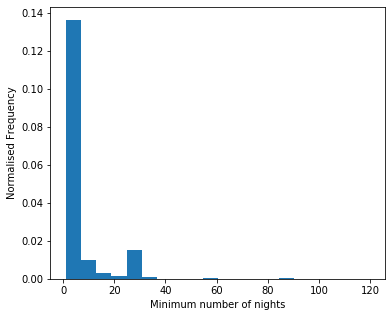

In [34]:
# Select minimum_nights and more_than_1_listing post where minimum nights is less than 120
grouped_nh = df[df.minimum_nights <= 120].loc[:,('minimum_nights','more_than_1_listing')]

# Plot data
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
ax = grouped_nh.loc[:,('minimum_nights')].plot(kind = 'hist', density=True, bins = 20)
ax.set_xlabel('Minimum number of nights')
ax.set_ylabel('Normalised Frequency');

How many of those 30 night stays are these hotel-type companies? I'm not sure if we can easily identify which hosts are which. We observed earlier that most hosts (~85 %) only list 1 property, so we could use this criteria as a proxy for identifying hosts which fall into the 'hotel-type' category. If we split our data into those with 1 listing and those with more than 1 property, what happens to the distributions?

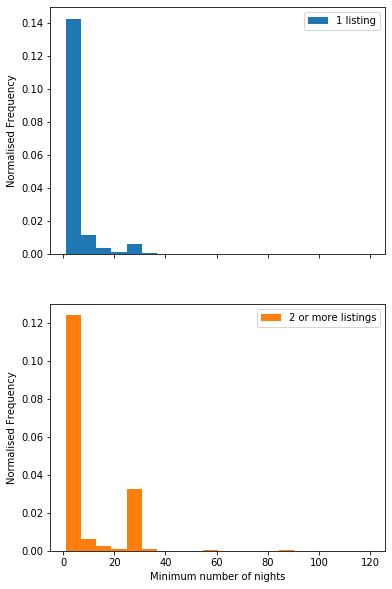

In [35]:
# Plot normalized histograms based on whether the host lists 1 property or more than 1 property.

# Plot data
#fig = plt.figure(figsize=(6,5));
ax = grouped_nh.pivot(columns = 'more_than_1_listing', values = 'minimum_nights').plot(kind = 'hist', density=True, bins = 20, subplots = True, figsize=(6,10));
ax[1].set_xlabel('Minimum number of nights');
ax[0].set_ylabel('Normalised Frequency');
ax[1].set_ylabel('Normalised Frequency');

When we split our data into two different populations, we can see the distributions are not the same. Listings which require a minimum of 30/60/90 nights are much more frequent in the histogram for hosts with 2 or more listings!

### What type of listing is most popular?

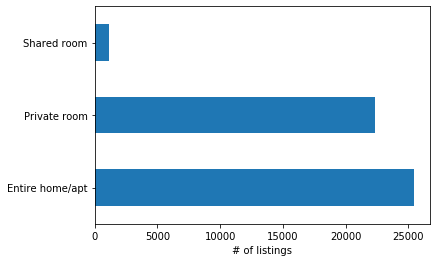

In [36]:
# Counts of different room types
fig = plt.figure()
ax = fig.add_subplot(111)
ax = df.room_type.value_counts().plot.barh();
ax.set_xlabel('# of listings');

Entire home/apartments are most popular, followed by private rooms and finally shared rooms are by far the least advertised. 

We might expect that the different types of listings can demand more or less money. For example, entire homes can probably charge more per night than a shared room. Let's plot some boxplots:

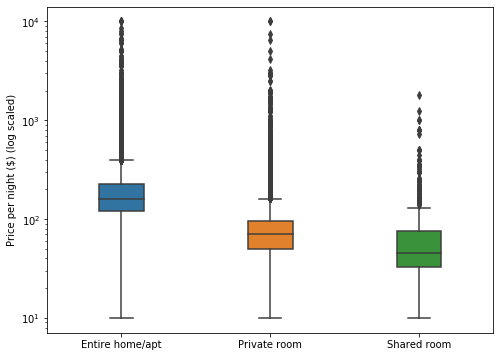

In [37]:
fig = plt.figure(figsize = [8,6])
ax = fig.add_subplot(111)

median_order = df.groupby(by=['room_type'])['price'].median().sort_values(ascending=False).index

sns.boxplot(data = df, y = 'price', x = 'room_type', ax = ax, width = 0.3, order = median_order)

ax.set_yscale('log')
ax.set_xlabel('')
ax.set_ylabel('Price per night ($) (log scaled)');

In [38]:
df.groupby(by=['room_type'])['price'].median()

room_type
Entire home/apt    160
Private room        70
Shared room         45
Name: price, dtype: int64

...and this seems to be the case. Entire homes or apartments can charge more than private rooms and private rooms can charge more than shared rooms.

Are these statistically significant differences though? To test this, we first need to see whether the data is normal or not. From looking at the boxplots, this seems unlikely but we can visually check more fomally by using [Q-Q plots](https://data.library.virginia.edu/understanding-q-q-plots/). If the data is normal, it will fall along the plotted line:

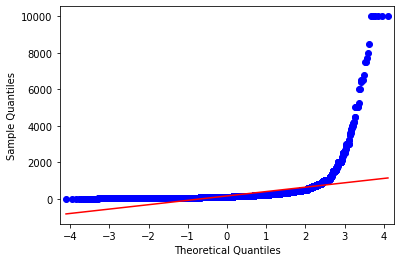

In [39]:
# Make a Q-Q plot:
qqplot(df['price'], line = 's');

So, this data is definitely not normal! We could also use statistical tests like the Shaprio-Wilk test to test for normality. It's not really necessary for this dataset anyway in the context of the Q-Q plot, but we'll perform it anyway for completeness:

In [40]:
from scipy.stats import shapiro

stat, p = shapiro(df['price'])
print(f'Statistics= {round(stat,4)}, p = {round(p,5)}')
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics= 0.3003, p = 0.0
Sample does not look Gaussian (reject H0)


C:\Users\Mike\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Now we've rejected the null hypothesis that the data is normal, we can use the [Kruskal-Wallis test](https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/):

In [41]:
price_apartment = df.price[df.room_type == 'Entire home/apt']
price_private_room = df.price[df.room_type == 'Private room']
price_shared_room = df.price[df.room_type == 'Shared room']

# compare samples
stat, p = kruskal(price_apartment, price_private_room, price_shared_room)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('These data come from different distributions (reject H0)')

Statistics=-358840.365, p=1.000
Same distributions (fail to reject H0)


C:\Users\Mike\Anaconda3\lib\site-packages\scipy\stats\stats.py:5879: RuntimeWarning: overflow encountered in long_scalars
  h = 12.0 / (totaln * (totaln + 1)) * ssbn - 3 * (totaln + 1)


The results of this test reveal that there is a significant difference in cost between the three types of listings, but what we'd really like to know is where those differences lie. To answer this we can use the post-hoc [Dunn's test](https://stats.stackexchange.com/tags/dunn-test/info):

In [42]:
# Perform post-hoc Dunn's test with bonferroni correction (to control for multiple comparisons)
sph.posthoc_dunn(df, val_col = 'price', group_col = 'room_type', p_adjust = 'bonferroni')

Entire home/apt  Private room  Shared room
Entire home/apt            -1.00          0.00         0.00
Private room                0.00         -1.00         0.00
Shared room                 0.00          0.00        -1.00

The dunn's test show that all pairs are significantly different. In other words entire homes/apartments are more expensive than private rooms and shared rooms. Private rooms are more expensive than shared rooms (but not entire homes/apartments). And finally, shared rooms are cheapest of all!

When we look at the distributions for the cost per night as a function of room type we can get a better idea for how different the prices are. We can also see another cool feature of this data: it seems like the hosts adjust their prices to nice round numbers, like \\$200, \\$250, \\$300 etc... and this is true for all room types (note I've limited the x-axis for the purposes of visualisation).

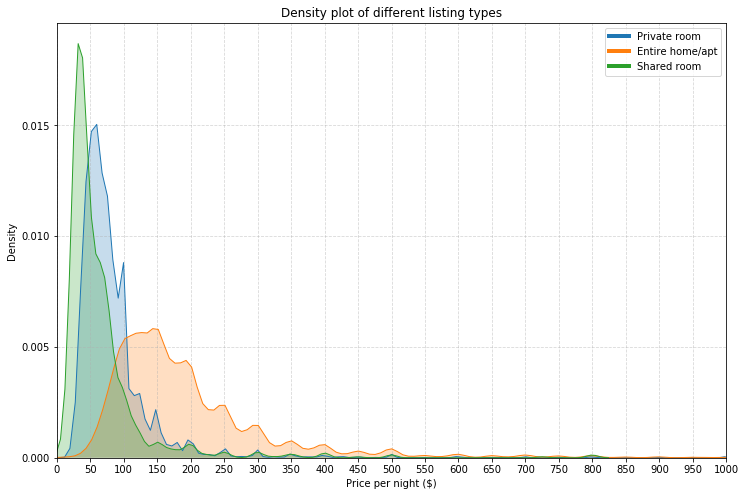

In [43]:
fig = plt.figure(figsize=(12,8))

# Change theme just for this figure
#with sns.axes_style("darkgrid"):
ax = fig.add_subplot(111)

# Subset and plot data according to roomtype (rt)
for rt in df.room_type.unique():
    # Subset data by room type and limit prices to 1000 for visualisation
    subset = df[(df['room_type'] == rt) & (df['price'] < 1000)]
    
    # Draw the density plot for each subset
    sns.distplot(subset['price'], 
                 hist = False, 
                 kde = True,
                 kde_kws = {'linewidth': 1, 'shade': True},
                 label = rt, ax = ax)


plt.xticks(np.arange(0, 1100, 50))
plt.yticks(np.arange(0, 0.02, 0.005))
ax.grid(which='both', axis='both', linestyle='--', alpha = 0.5)
ax.set_xlim([0,1000])
leg = ax.legend(title = '')

for line in leg.get_lines():
    line.set_linewidth(4.0)
    
plt.title('Density plot of different listing types')
ax.set_xlabel('Price per night ($)')
ax.set_ylabel('Density');

### Which area is most expensive?

So we might expect price to change not only as a function of room type but also as a function of it's location too. 

Let's begin by grouping our data by borough and calculate some summary statistics:

In [44]:
# Group our original dataframe by neighbourhood_group and for the price column, find the min, mean, median and max
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.core.groupby.GroupBy.mean.html
df.groupby('neighbourhood_group')['price'].agg(["count", min, "mean", "median", max]).reset_index()

neighbourhood_group  count  min   mean  median    max
0               Bronx   1090   10  87.58      65   2500
1            Brooklyn  20095   10 124.44      90  10000
2           Manhattan  21660   10 196.88     150  10000
3              Queens   5666   10  99.52      75  10000
4       Staten Island    373   13 114.81      75   5000

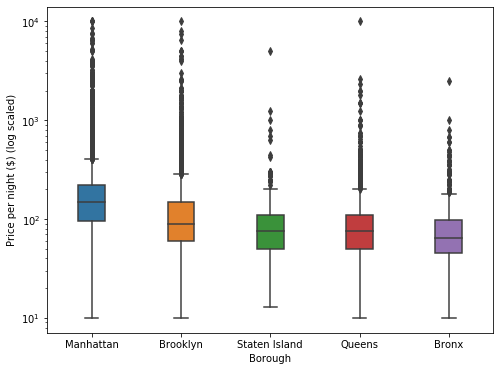

In [45]:
# Plot boxplot of neighbourhood_group vs price, excluding values for price greater than 10000
fig = plt.figure(figsize = [8,6])
ax = fig.add_subplot(111)

median_order = df.groupby(by=['neighbourhood_group'])['price'].median().sort_values(ascending=False).index

sns.boxplot(data = df, y = 'price', x = 'neighbourhood_group', ax = ax, width = 0.3, order = median_order)

ax.set_yscale('log')
ax.set_xlabel('Borough')
ax.set_ylabel('Price per night ($) (log scaled)');

These results show Manhattan is the most expensive area and Bronx is the cheapest. However, can we get any more insight from the data? In addition to the borough column, we also have the neighbourhood column. Let's plot that information! 

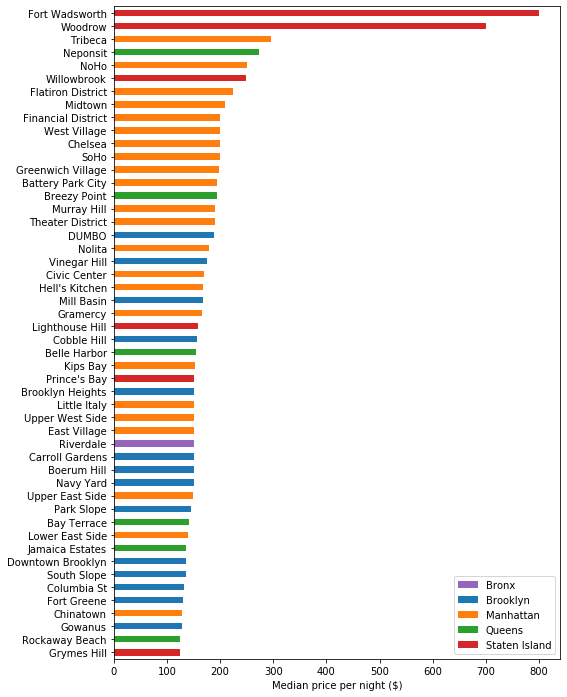

In [46]:
# Get mean/median per neighbourhood area
per_neighbourhood = df.loc[:,('price', 'neighbourhood', 'neighbourhood_group')].groupby(['neighbourhood','neighbourhood_group']).agg(['mean', 'median','count'])

# Arrange by median price and limit to first 50 most expensive neighbourhood boroughs
per_neighbourhood = per_neighbourhood.sort_values(('price','median'), ascending = False).reset_index().head(50)

# Define colours for each neighbourhood_group
colors = {'Bronx':'#9467bd', 
          'Brooklyn':'#1f77b4', 
          'Manhattan':'#ff7f0e', 
          'Queens':'#2ca02c', 
          'Staten Island':'#d62728'}

# Get a list of colours which we can use in the plot
col_fn = per_neighbourhood['neighbourhood_group'].apply(lambda x: colors[x])

# Define custom legend elements
legend_elements = [Patch(facecolor = '#9467bd', label = 'Bronx'),
                Patch(facecolor = '#1f77b4', label = 'Brooklyn'),
                Patch(facecolor = '#ff7f0e', label = 'Manhattan'),
                Patch(facecolor = '#2ca02c', label = 'Queens'),
                Patch(facecolor = '#d62728', label = 'Staten Island')]

# Plot median
fig = plt.figure(figsize = [8,12])
ax = fig.add_subplot(111)
ax = per_neighbourhood.plot.barh(x = 'neighbourhood', y=('price','median'), color = col_fn, ax = ax)
ax.legend(handles = legend_elements)
ax.invert_yaxis()
ax.set_ylabel('')
ax.set_xlabel('Median price per night ($)');

Interesting. So it looks like the two most expensive neighbourhoods are located on Staten Island. This is surprising since the summary stats above suggest this area is cheaper than both Manhatten and Brooklyn. Let's take a closer look at our summarised data to see what is going on:

In [47]:
per_neighbourhood.head(10)

neighbourhood neighbourhood_group  price             
                                            mean median count
0      Fort Wadsworth       Staten Island 800.00 800.00     1
1             Woodrow       Staten Island 700.00 700.00     1
2             Tribeca           Manhattan 490.64 295.00   177
3            Neponsit              Queens 274.67 274.00     3
4                NoHo           Manhattan 295.72 250.00    78
5         Willowbrook       Staten Island 249.00 249.00     1
6   Flatiron District           Manhattan 341.93 225.00    80
7             Midtown           Manhattan 282.72 210.00  1545
8  Financial District           Manhattan 225.49 200.00   744
9        West Village           Manhattan 267.68 200.00   768

Ah! so it looks like there is only one property in Fort Wadsworth, Woodrow and Willowbrook, so we don't have a 'true' median/mean value. Let's remove neighbourhoods with less than 10 listings and see how that affects our graph:

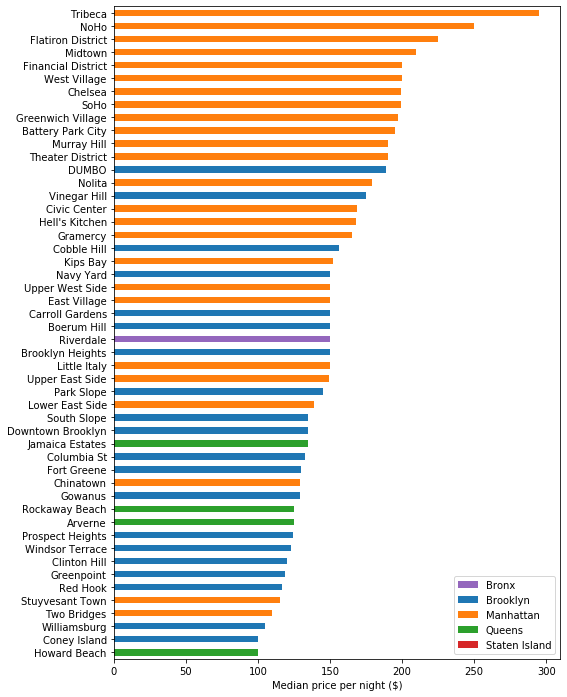

In [48]:
# Get mean/median per neighbourhood area
per_neighbourhood = df.loc[:,('price', 'neighbourhood', 'neighbourhood_group')].groupby(['neighbourhood','neighbourhood_group']).agg(['mean', 'median','count'])

# Rename columns
per_neighbourhood.columns = ['_'.join(col).rstrip('_') for col in per_neighbourhood.columns.values]

# Subset data where we have at least 10 listings, arrange by median price and 
# limit to first 50 most expensive neighbourhood boroughs
per_neighbourhood = per_neighbourhood[per_neighbourhood.price_count >= 10].sort_values('price_median', ascending = False).reset_index().head(50)

# Define colours for each neighbourhood_group
colors = {'Bronx':'#9467bd', 
          'Brooklyn':'#1f77b4', 
          'Manhattan':'#ff7f0e', 
          'Queens':'#2ca02c', 
          'Staten Island':'#d62728'}

# Get a list of colours which we can use in the plot
col_fn = per_neighbourhood['neighbourhood_group'].apply(lambda x: colors[x])

# Define custom legend elements
legend_elements = [Patch(facecolor = '#9467bd', label = 'Bronx'),
                Patch(facecolor = '#1f77b4', label = 'Brooklyn'),
                Patch(facecolor = '#ff7f0e', label = 'Manhattan'),
                Patch(facecolor = '#2ca02c', label = 'Queens'),
                Patch(facecolor = '#d62728', label = 'Staten Island')]

# Plot median
fig = plt.figure(figsize = [8,12])
ax = fig.add_subplot(111)
ax = per_neighbourhood.plot.barh(x = 'neighbourhood', y='price_median', color = col_fn, ax = ax)
ax.legend(handles = legend_elements)
ax.invert_yaxis()
ax.set_ylabel('')
ax.set_xlabel('Median price per night ($)');

This makes more sense! We see the oranges of Manhattan dominate, followed by Brooklyn in blue and then some green from Queens. Notably there is one entry from the Bronx: Riverdale. I wonder if that is of significance?

## Geospatial analysis

As I'm from the UK I'm not really familiar with the different boroughs/neighbourhoods in NYC. So in an effort to educate myself, let's begin by plotting the latitude vs longitude and colour code based on `neighbourhood_group` (borough) so I can get a better understanding of where these places are (this is also useful for spotting whether there are any longitude/latitude outliers).

To make the plots below where the dots are overlayed onto a map of NYC, we first have to know where the neighbourhood boundaries are. Thankfully, [this very cool website](https://data.cityofnewyork.us/City-Government/Neighborhood-Tabulation-Areas/cpf4-rkhq) provides the exact data we're after, and in a variety of formats to boot! One of those formats is a shape (`shp`) file which contains '[well known text](https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry)' (wkt). This is a commonly used markdown format for describing geomtetric shapes. We can use the `geopandas` library to import this file, interpret wkt, and plot our data.

In [49]:
# Import neighbourhood boundaries (found here: https://data.cityofnewyork.us/City-Government/Neighborhood-Tabulation-Areas/cpf4-rkhq)
neighbourhood_boundaries = gpd.read_file('./data/neighbourhood_boundaries/geo_export_0905123d-bfa7-44fa-8506-060bbaa9baf6.shp')

# Rename columns
neighbourhood_boundaries.rename(columns={'ntaname':'neighbourhood', 'boro_name':'neighbourhood_group'}, inplace=True)

# Drop unnecessary column
neighbourhood_boundaries = neighbourhood_boundaries.drop(['boro_code','county_fip'], axis = 1)

# Note the geometry column
neighbourhood_boundaries.head()

neighbourhood_group ntacode   neighbourhood  shape_area  shape_leng  \
0            Brooklyn    BK88    Borough Park 54005018.75    39247.23   
1              Queens    QN51     Murray Hill 52488276.48    33266.90   
2              Queens    QN27   East Elmhurst 19726845.26    19816.71   
3              Queens    QN07          Hollis 22887772.77    20976.34   
4           Manhattan    MN06  Manhattanville 10647077.61    17040.69   

                                            geometry  
0  POLYGON ((-73.97604935657381 40.63127590564677...  
1  POLYGON ((-73.80379022888246 40.77561011179248...  
2  POLYGON ((-73.86109724401859 40.7636644770877,...  
3  POLYGON ((-73.75725671509139 40.71813860166257...  
4  POLYGON ((-73.94607828608069 40.8212632160616,...

Now we've got that info, we can plot the neighbourhoods in grey and then overlay our listing locations on top:

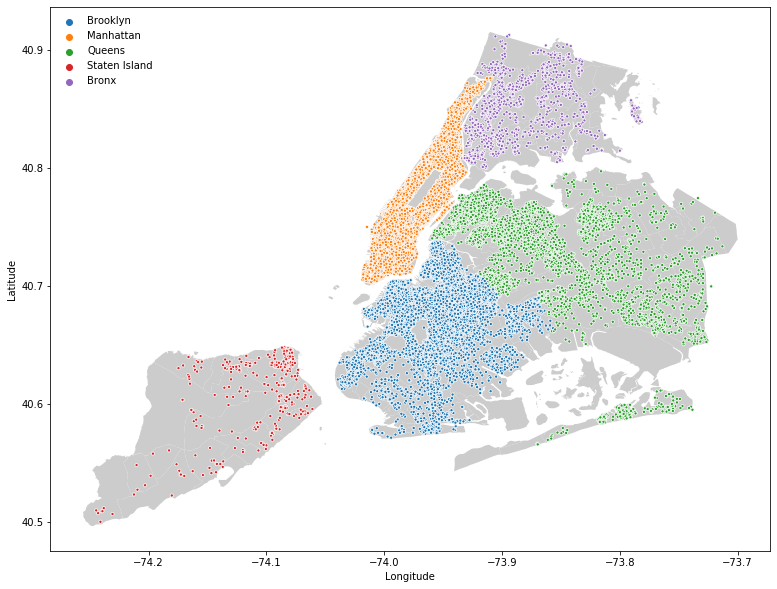

In [50]:
# Initialise plot
fig = plt.figure(figsize = (16,10))
ax = fig.add_subplot(111)

# Define map base
base = neighbourhood_boundaries.plot(ax = ax, color = "#CCCCCC")

# Plot our raw data points
dots = sns.scatterplot(ax = ax, x = df.longitude, y = df.latitude, hue = df.neighbourhood_group, s = 10)

# Set aspect ratio to 1
ax.set_aspect('equal')

# Format legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles = handles[1:], labels = labels[1:], loc = 'upper left', frameon = False)

# X/Y/legend labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude');

So, Staten Island is an island. Manhatten is the important bit where Central Park (which you can see by the absence of orange dots), Friends and all the big skyscrapers in movies are. Brooklyn is next door to Manhatten. Now I have a comprehensive understanding of New York City's geography, I can colour-code by price and see if the expensive properties are clustered in any particular area:

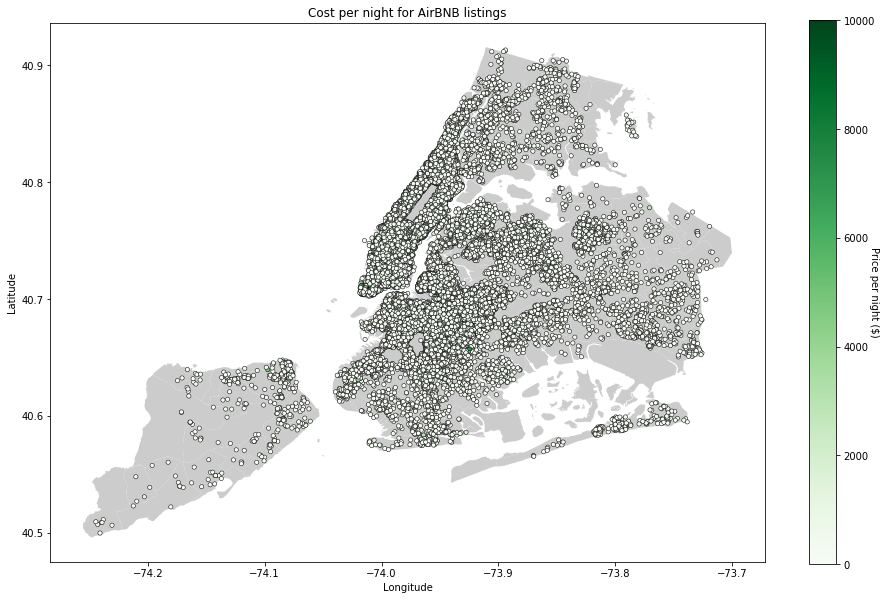

In [51]:
# Initialise plot
fig = plt.figure(figsize = (16,10))
ax = fig.add_subplot(111)

# Replace seaborns normal discrete legend with a continuous colourbar to more accurately represent the data.
base_plot = neighbourhood_boundaries.plot(ax = ax, color = "#CCCCCC")

kwargs = {'edgecolor' : "black", # for edge color
          'linewidth' : 0.5, # line width of spot,
          'size' : 10
          }

# plot the long/lat on x/y and colour code with respect to price.
ax = sns.scatterplot(x = df.longitude, y = df.latitude, hue = df.price, palette='Greens', **kwargs)
# Set aspect ratio to 1:1 for x:y
ax.set_aspect('equal')

# Remove default legend
ax.get_legend().remove()

# Labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set(title = "Cost per night for AirBNB listings");

# Continuous colour bar
norm = plt.Normalize(0, df.price.max())
sm = plt.cm.ScalarMappable(cmap = "Greens", norm = norm)
sm.set_array([])

# Add color bar
cbar = fig.colorbar(sm, ax = ax)
cbar.set_label('Price per night ($)', rotation=270)

This isn't very informative. There are far too many data points to get a clear picture of what's going on and any subtle changes in price are getting drowned out by the few properties listed at $10,000 per night. 

Perhaps instead we can look at the mean or median for each neighbourhood? One issue here though is how do we plot the mean location? We can't take a 'normal' average because longitude and latitude are circular. So below I've defined the following functions which take our latitude/longitude values and finds a circular mean (having said that, given how close the values are, a 'normal' mean might be fine):

In [52]:
# Functions to help find the mean long/lat of a given set of points
# Calculations: http://mathforum.org/library/drmath/view/63491.html and 
# https://stackoverflow.com/questions/6671183/calculate-the-center-point-of-multiple-latitude-longitude-coordinate-pairs

def cart_coords(row):
    '''
    Find carteisan coordinates for given lat/long
    '''
    
    # Convert decimal lat/long to radians
    rad_lat = row['latitude'] * (np.pi/180)
    rad_lon = row['longitude'] * (np.pi/180)
    
    # Convert lat/long to cartesian (x, y, z) coords
    x = np.cos(rad_lat) * np.cos(rad_lon)
    y = np.cos(rad_lat) * np.sin(rad_lon)
    z = np.sin(rad_lat)
    
    # Return coordinates
    return pd.Series([x, y, z])

def mean_coords(frame):
    '''
    Find the average cartesian coordinates for a group, then convert back to lat/long
    '''
    
    # Length of group
    n = len(frame)
    
    # Mean x,y,z coordinates
    #x, y, z is hard coded here. Can't figure out how to pass variables to function in apply
    mean_x = sum(frame.x)/n
    mean_y = sum(frame.y)/n
    mean_z = sum(frame.z)/n
    
    # Convert cartesian coords back to lat/long
    hyp = np.sqrt(mean_x**2 + mean_y**2)
    lon = np.arctan2(mean_y, mean_x) * (180/np.pi)
    lat = np.arctan2(mean_z, hyp) * (180/np.pi)
    
    # Format output of function so it returns to a dataframe.
    cols = ['lat', 'lon']
    return pd.Series((lat, lon), index = cols)

In [53]:
# Add coordinates to raw data
df[['x','y','z']] = df.apply(cart_coords, axis = 1)

# Find mean coordinations for each neighbourhood
mean_neighbourhood_coords = df.groupby('neighbourhood').apply(mean_coords)

# Remove MultiIndex to make life easier
mean_neighbourhood_coords.reset_index(inplace = True)

# Confirm data looks like we'd expect
mean_neighbourhood_coords.sample(5, random_state = 1234)

neighbourhood   lat    lon
5           Bath Beach 40.60 -74.01
179          Soundview 40.83 -73.87
6    Battery Park City 40.71 -74.02
92   Greenwich Village 40.73 -74.00
180        South Beach 40.59 -74.09

We've now got a reference dataframe with the average longitude/latitude for the listings within each of our neighbourhoods. Let's merge this dataframe with the median prices for each neighbourhood and then finally plot our data:

In [54]:
# Get mean and median price per neighbourhood as we have before
price_per_neighbourhood = df.loc[:,('price', 'neighbourhood', 'neighbourhood_group')].groupby(['neighbourhood','neighbourhood_group']).agg(['mean', 'median','count'])

# Rename columns
price_per_neighbourhood.columns = ['_'.join(col).rstrip('_') for col in price_per_neighbourhood.columns.values]

# Sort by median (not strictly needed) and reset index. Do not limit to 50 neighbourhoods this time
price_per_neighbourhood = price_per_neighbourhood.sort_values('price_median', ascending = False).reset_index()

# left join price_per_neighbourhood and mean_neighbourhood_coords
price_per_neighbourhood = pd.merge(price_per_neighbourhood,
                             mean_neighbourhood_coords[['neighbourhood','lat','lon']],
                             on='neighbourhood')

# Exclude neighbourhoods with less than 10 listings
price_per_neighbourhood = price_per_neighbourhood[price_per_neighbourhood.price_count >= 10]
price_per_neighbourhood.sample(5, random_state = 1234)

neighbourhood neighbourhood_group  price_mean  price_median  \
42   Downtown Brooklyn            Brooklyn      150.35        135.00   
167            Maspeth              Queens       83.65         65.00   
125      East Flatbush            Brooklyn      104.22         75.00   
100   Roosevelt Island           Manhattan      113.26         80.00   
187         Mount Hope               Bronx       77.50         60.00   

     price_count   lat    lon  
42            83 40.69 -73.98  
167          110 40.73 -73.90  
125          500 40.65 -73.94  
100           77 40.76 -73.95  
187           20 40.85 -73.91

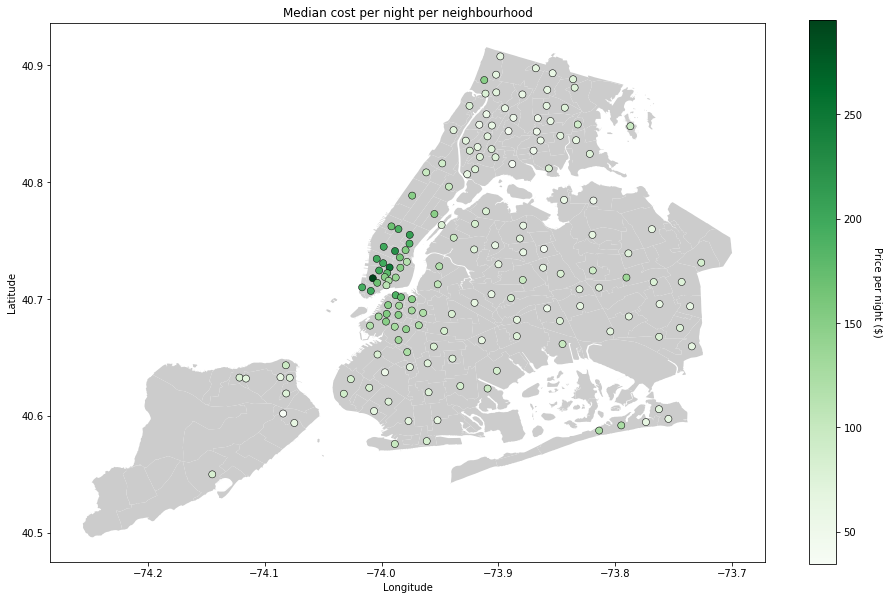

In [55]:
# Aim: Plot median price per neighbourhood
# Intialise figure
fig = plt.figure(figsize = (16,10))
ax = fig.add_subplot(111)

# Define base map.
base_plot = neighbourhood_boundaries.plot(ax = ax, color = "#CCCCCC")

# Replace seaborns normal discrete legend with a continuous colourbar to more accurately represent the data.
norm = plt.Normalize(price_per_neighbourhood.price_median.min(), price_per_neighbourhood.price_median.max())
sm = plt.cm.ScalarMappable(cmap = "Greens", norm = norm)
sm.set_array([])

# Format dots.
kwargs = {'edgecolor':"black", # for edge color
          'linewidth':0.5, # line width of spot
         }

# plot the long/lat on x/y and colour code with respect to median price.
sns.scatterplot(ax = ax, y = price_per_neighbourhood.lat, x = price_per_neighbourhood.lon, s = 50, hue = price_per_neighbourhood.price_median, palette = 'Greens', **kwargs)
ax.get_legend().remove()

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set(title = "Median cost per night per neighbourhood");

# Add colourbar
cbar = fig.colorbar(sm, ax = ax)
cbar.set_label('Price per night ($)', rotation=270, labelpad = 20)

plt.show()

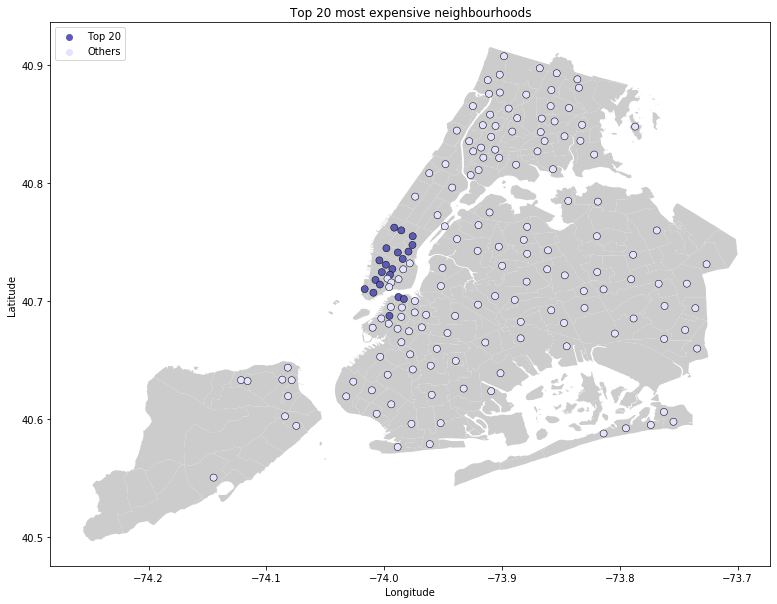

In [56]:
# Aim: Partion data into binary groups: top 20 most expensive or not and plot these

# Not sure of a better way to do this
# Found 20th lowest median manually and then mapped value
price_per_neighbourhood.loc[price_per_neighbourhood['price_median'] >= 152, 'top20'] = "Top 20"
price_per_neighbourhood.loc[price_per_neighbourhood['price_median'] < 152, 'top20'] = "Others"

fig = plt.figure(figsize = (16,10))
ax = fig.add_subplot(111)

# Base plot again
base_plot = neighbourhood_boundaries.plot(ax = ax, color = "#CCCCCC")

kwargs  =   {'edgecolor' : "black", # for edge color
             'linewidth' : 0.5, # line width of spot
            }

# Manually define colours for top 20/remaining 
cols = ["#5C5BB8","#E3E3FF"]

# Plot data
sns.scatterplot(ax = ax, y = price_per_neighbourhood.lat, x = price_per_neighbourhood.lon, s = 50, hue = price_per_neighbourhood.top20, palette=cols, **kwargs)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set(title = "Top 20 most expensive neighbourhoods");

# Format legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], loc='upper left')

plt.show();

So these figures help contextualise the results above where I looked at the most expensive neighbourhoods. We can see that, yes, Manhatten dominates and then outside of Manhatten, the other expensive neighbourhoods are those in Brooklyn which are adjacent to Manhatten.

## Segue to subways

Anecdotally, when I'm looking for an AirBNB, one key factor in determining where to stay is the distance of the place to public transport. That convenience always seems to come at a premium though. I wonder if that is true for NYC? Could I use this dataset to find appropriate properties for my trips to NYC?

So far in our data analysis, we've only worked with decimal degrees (for our longitudes and latitudes), but if we want to find distances between AirBNB locations and subway stations, we need to work in measurements of distance (e.g. feet, miles, metres, etc). Thankfully, this can be achieved using the  `shapely` and `geopandas` libraries. 

To begin let's import the locations of subway stations using geopandas:

In [57]:
# https://data.cityofnewyork.us/Transportation/Subway-Stations/arq3-7z49
# Read stations shape file into a geopandas dataframe
stations = gpd.read_file('./data/subway_stations/geo_export_adc3544f-52dd-410f-b2cb-88e24c1b796d.shp')

# Drop unneeded columns
stations = stations.drop(['url','objectid','notes'], axis = 1)

# https://data.cityofnewyork.us/Transportation/Subway-Lines/3qz8-muuu
# Read in subway lines shape data
subway_lines = gpd.read_file('./data/subway_lines/geo_export_148afeff-7e4f-482b-901e-90acc54f8ca0.shp')

# Drop unneeded columns
subway_lines = subway_lines.drop(['url','objectid','id'], axis = 1)

Now we can plot the stations:

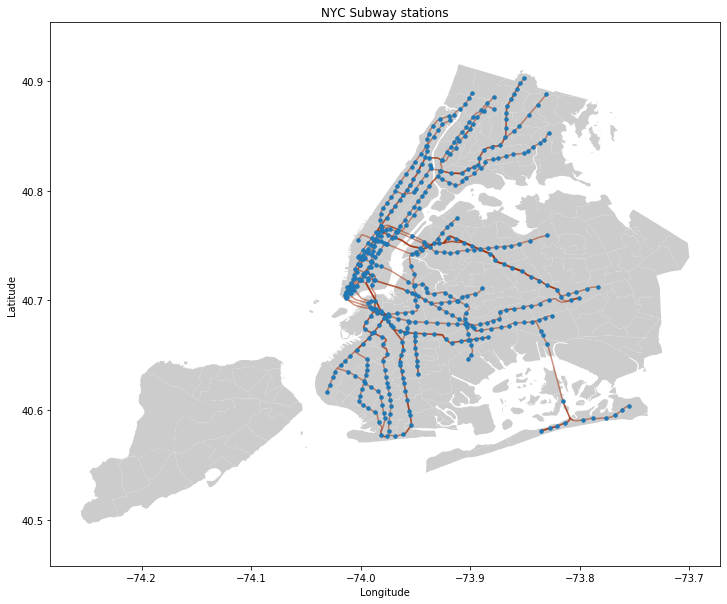

In [58]:
# Plot subway stations
fig = plt.figure(figsize = (12,10))
ax = fig.add_subplot(111)

base_plot = neighbourhood_boundaries.plot(ax = ax, color = "#CCCCCC", zorder = 1)
subway_lines_plot = subway_lines.plot(ax = ax, color = "#9f2800", alpha = 0.5, zorder = 2)
subway_plot = stations.plot(ax = ax, markersize = 12, zorder = 3)

plt.axis('equal')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set(title = "NYC Subway stations");

A key piece of information that is used to determine distances is the coordinate reference system (CRS), which defines where points are in space (see [here](https://residentmario.github.io/geoplot/user_guide/Working_with_Geospatial_Data.html)). Each shape file has a defined CRS which is imported automatically by `geopandas` and can be checked as follows:

In [59]:
print(f'The CRS used by the subway stations file: {stations.crs}')
print(f'The CRS used by the neighbourhood boundaries file: {neighbourhood_boundaries.crs}')

The CRS used by the subway stations file: {'init': 'epsg:4326'}
The CRS used by the neighbourhood boundaries file: {'init': 'epsg:4326'}


This CRS, 4326, is used by both datasets and refers to the WGS84 coordinate system i.e. coordinates are in decimal degrees. This makes sense if you look at the raw data (see above). Now we've determined that a CRS is defined for the data we can conveniently convert from decimal degrees to the [2263 coordinate system](https://spatialreference.org/ref/epsg/nad83-new-york-long-island-ftus/) which is in feet using `to_crs`:

In [60]:
# Convert CRS to 2263 system
stations = stations.to_crs(epsg = 2263)
neighbourhood_boundaries = neighbourhood_boundaries.to_crs(epsg = 2263)
subway_lines = subway_lines.to_crs(epsg = 2263)

If we plot our data now, we can see the values for the x- and y-axes have changed from decimal degrees to feet:

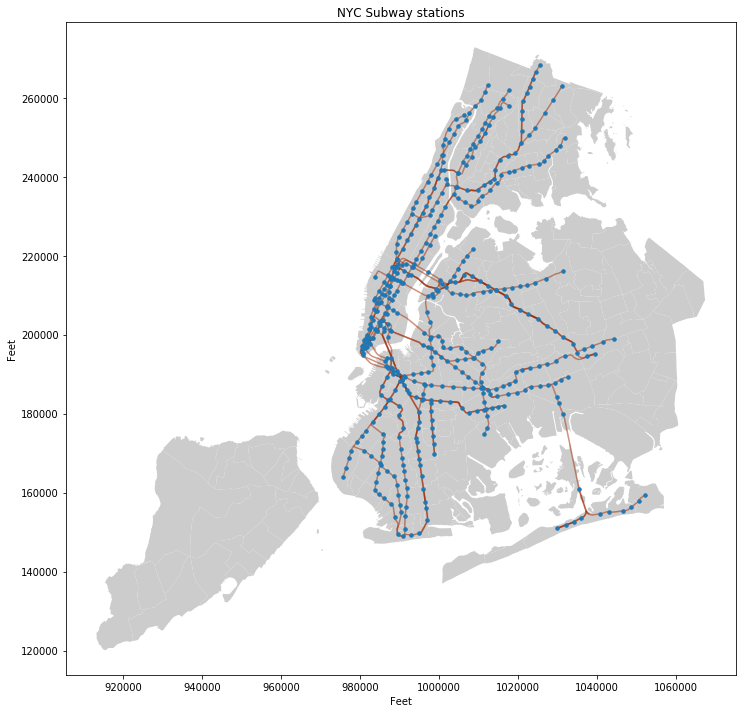

In [61]:
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
base_plot = neighbourhood_boundaries.plot(ax = ax, color = "#CCCCCC", zorder = 1)
subway_lines_plot = subway_lines.plot(ax = ax, color = "#9f2800", alpha = 0.5, zorder = 2)
subway_plot = stations.plot(ax = ax, markersize = 12, zorder = 3)

plt.axis('equal')
ax.set_xlabel('Feet')
ax.set_ylabel('Feet')
ax.set(title = "NYC Subway stations");

Since we're interested in properties near to subway stations we can define a radius around each subway station, known as a 'buffer':

In [62]:
# Add buffer columns to stations dataframe
stations['buffer_500ft'] = stations.geometry.buffer(500)

# Make a new geopandas dataframe with only the buffer set too a geometry.
# This is necessary (I think) because you can only have one geometry column per df
buffer_500ft = gpd.GeoDataFrame(stations[['line','name','buffer_500ft']], geometry = 'buffer_500ft')

# Redefine CRS for each subset dataframe - necessary because subsetting above loses the crs information
buffer_500ft.crs = {'init': 'epsg:2263'}

Remember that we imported our AirBNB listings as a normal `csv` file: it doesn't contain any `wkt`. However it does have latitude and longitude values in separate columns. Before we can go any further we will want to convert these values to `wkt` and convert the whole dataframe to a geopandas dataframe:

In [63]:
# Add a new geometry column to our original dataframe
df_geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]
geo_df = gpd.GeoDataFrame(df, geometry = df_geometry)

# This should work, but doesn't for reasons I can't figure out... points_from_xy is just a wrapper around the above code
#geo_df = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(data.longitude, data.latitude))

# Define crs 
geo_df.crs = {'init': 'epsg:4326'}
# Convert crs to 2263
geo_df = geo_df.to_crs(epsg = 2263)

Finally we can perform an intersectional spatial join between our original dataframe and buffer (the warning below is a known bug which apparently does not effect output):

In [64]:
# Perform left join and find airbnbs which rest in buffer zone.
# The resultant warning is a known bug and doesn't effect output
geo_df_500ft = gpd.sjoin(geo_df,
                      buffer_500ft,
                      how = 'left',
                      op = 'intersects')

geo_df_500ft.head()

C:\Users\Mike\Anaconda3\lib\site-packages\geopandas\tools\sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


id                                         name_left  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington     40.65     -73.97   
1     Jennifer           Manhattan       Midtown     40.75     -73.98   
2    Elisabeth           Manhattan        Harlem     40.81     -73.94   
3  LisaRoxanne            Brooklyn  Clinton Hill     40.69     -73.96   
4        Laura           Manhattan   East Harlem     40.80     -73.94   

         room_type  price  ...  more_than_1_listing  days_since      cut_days  \
0     Private room    149  ...   2 or more listings    262 days   3-12 months   
1  Entire home/apt    225  ...   2 or more listings     48 days  1 - 3 months   
2     Private room    150  ...            1 listing         NaT           NaN   
3  Entire home/apt     89  ...            1 listing      3 days      < 1 week   
4  Entire home/apt     80  ...            1 listing    231 days   3-12 months   

     x     y    z                                     geometry index_right  \
0 0.21 -0.73 0.65  POINT (991917.3034309624 175175.6553184732)         nan   
1 0.21 -0.73 0.65   POINT (988746.6482893158 213841.186162091)       59.00   
2 0.21 -0.73 0.65  POINT (1000333.670426247 234030.2026303638)         nan   
3 0.21 -0.73 0.65  POINT (995410.2671486619 188893.9674919459)         nan   
4 0.21 -0.73 0.65   POINT (999757.5496760185 230200.663769528)         nan   

      line           name_right  
0      NaN                  NaN  
1  B-D-F-M  42nd St - Bryant Pk  
2      NaN                  NaN  
3      NaN                  NaN  
4      NaN                  NaN  

[5 rows x 26 columns]

Now, I want to visually inspect these data to make sure the intersection has worked as expected. In the case of `geo_df_500ft`, we want to make sure a given listing is only present if it's within 500 ft of a station.

In order to plot this data, we need to do a couple of things. Firstly we want to drop the rows which don't have a station associated with them:

In [65]:
# keep columns which do have values in the station name column
geo_df_500ft_dropped = geo_df_500ft[pd.notna(geo_df_500ft.name_right)]

Next we'll want to drop duplicate listings (this occurs because a listing is within 500 feet of two or more stations). This might not be necessary when plotting the data since the points would be in the exact same position, but we'll get rid of duplicates anyway:

In [66]:
# Example listing with 1 more than one entry
geo_df_500ft_dropped[geo_df_500ft_dropped.id == 19169]

id                         name_left  host_id host_name  \
82  19169  Entire 2 Bedroom - Large & Sunny    73128    JoLynn   
82  19169  Entire 2 Bedroom - Large & Sunny    73128    JoLynn   

   neighbourhood_group    neighbourhood  latitude  longitude        room_type  \
82           Manhattan  Lower East Side     40.72     -73.99  Entire home/apt   
82           Manhattan  Lower East Side     40.72     -73.99  Entire home/apt   

    price  ...  more_than_1_listing  days_since     cut_days    x     y    z  \
82    285  ...            1 listing      8 days  1 - 4 weeks 0.21 -0.73 0.65   
82    285  ...            1 listing      8 days  1 - 4 weeks 0.21 -0.73 0.65   

                                       geometry index_right   line  \
82  POINT (987321.4185608412 201049.2847868135)       10.00  J-M-Z   
82  POINT (987321.4185608412 201049.2847868135)      369.00      F   

                name_right  
82  Delancey St - Essex St  
82  Delancey St - Essex St  

[2 rows x 26 columns]

In [67]:
# Drop duplicate rows. Each id is unique to a given listing, so we'll use that to identify duplicate entries for a given AirBNB listing.
# drop_duplicates keeps the first row when duplicates are found (it doesn't really matter which row is kept though). 
geo_df_500ft_dropped = geo_df_500ft_dropped.drop_duplicates(subset=['id'])

# Confirm only one row for this listing
geo_df_500ft_dropped[geo_df_500ft_dropped.id == 19169]

id                         name_left  host_id host_name  \
82  19169  Entire 2 Bedroom - Large & Sunny    73128    JoLynn   

   neighbourhood_group    neighbourhood  latitude  longitude        room_type  \
82           Manhattan  Lower East Side     40.72     -73.99  Entire home/apt   

    price  ...  more_than_1_listing  days_since     cut_days    x     y    z  \
82    285  ...            1 listing      8 days  1 - 4 weeks 0.21 -0.73 0.65   

                                       geometry index_right   line  \
82  POINT (987321.4185608412 201049.2847868135)       10.00  J-M-Z   

                name_right  
82  Delancey St - Essex St  

[1 rows x 26 columns]

Great! Now we've cleaned the data, we can plot it:

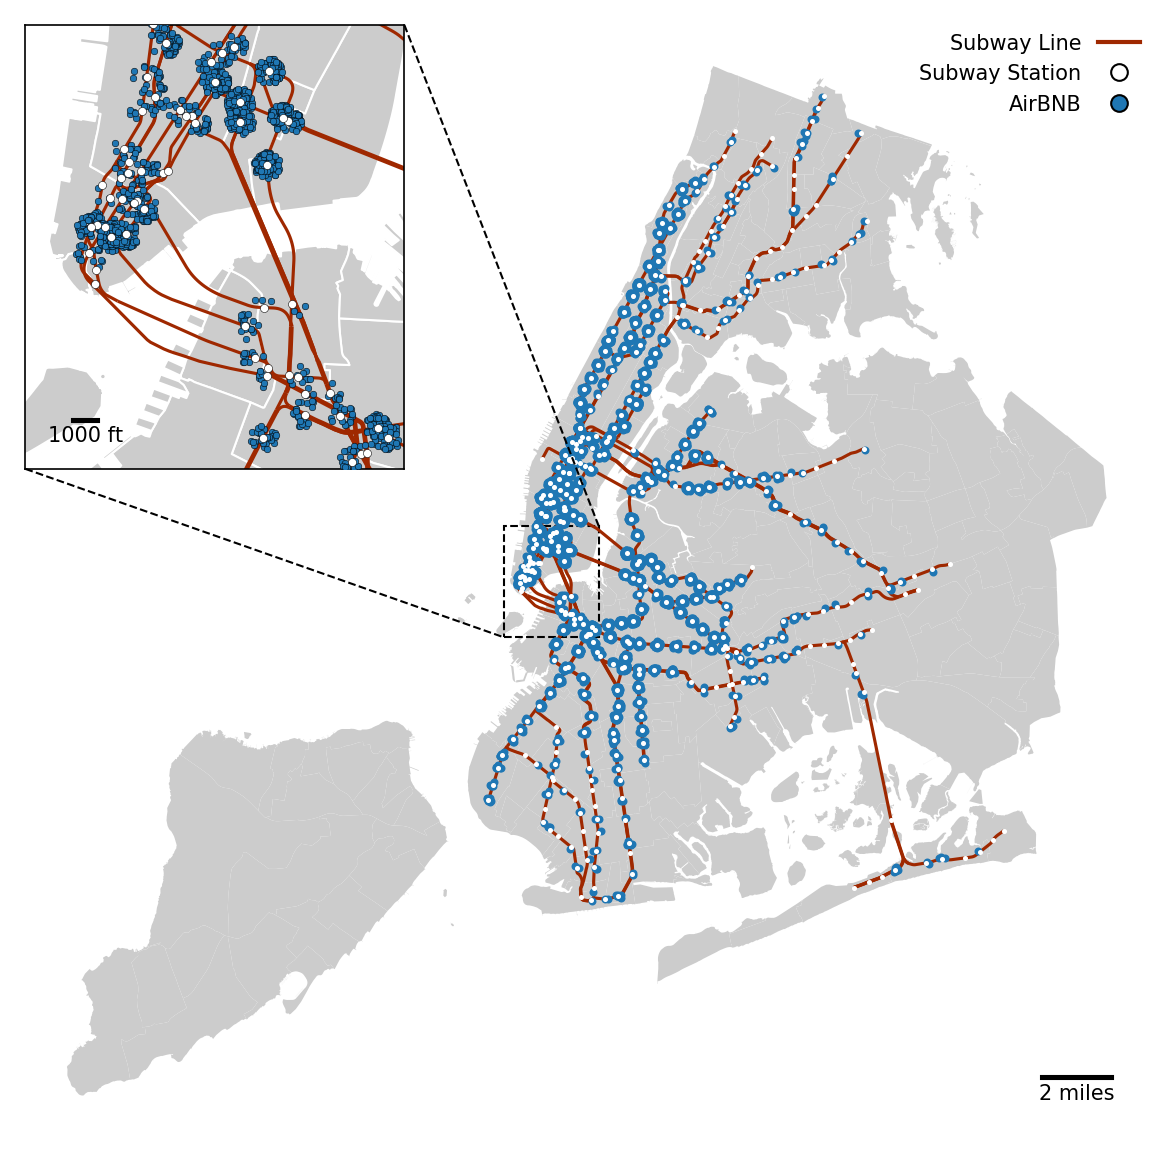

In [68]:
# Initalise figure
fig = plt.figure(figsize = (10,10), dpi = 150)
ax = fig.add_subplot(111)

#### Define main plot
# Base neighbourhoods
neighbourhood_boundaries.plot(ax = ax, color = "#CCCCCC", zorder = 1)
# Subway lines
subway_lines.plot(ax = ax, color = "#9f2800", zorder = 2)
# AirBNB listings
geo_df_500ft_dropped.plot(ax = ax, markersize = 8, zorder = 3)
# Subway stations
stations.plot(ax = ax, color = "#FFFFFF", markersize = 2, zorder = 4)

#### Define inset
axins = zoomed_inset_axes(ax, 4, loc = 2)
# Get approximate x,y bounds for inset around Manhattan
minx,miny,maxx,maxy =  neighbourhood_boundaries.query('neighbourhood_group == "Manhattan"').total_bounds

# Manually fine tune limits 
axins.set_xlim(minx+7000, maxx-18000)
axins.set_ylim(miny, maxy-55000)

#### Define inset plot
# Base neighbourhoods
neighbourhood_boundaries.plot(ax = axins, edgecolor = 'white', color = '#CCCCCC', zorder = 1)
# Subway lines
subway_lines.plot(ax = axins, color = "#9f2800", zorder = 2)

# Arguments for markers
kwargs  =   {'edgecolor' : "black", # for edge color
             'linewidth' : 0.25, # line width of spot
            }

# AirBNB listings
geo_df_500ft_dropped.plot(ax = axins, markersize = 10, zorder = 3, **kwargs)

# Subway stations
stations.plot(ax = axins, color = "#FFFFFF", markersize = 15, zorder = 4, **kwargs)

# Define location of inset and fine tune
mark_inset(ax, axins, loc1 = 1, loc2 = 3, fc = "none", lw = 1, ec = "0", linestyle = '--')

### Scalebar for main plot
scalebar_main = AnchoredSizeBar(ax.transData,
                           10560, '2 miles', 'lower right', 
                           pad=2,
                           color='black',
                           frameon=False,
                           size_vertical=500)
ax.add_artist(scalebar_main)

### Scalebar for inset
scalebar_ins = AnchoredSizeBar(axins.transData,
                           1000, '1000 ft', 'lower left', 
                           pad = 1,
                           color = 'black',
                           frameon = False,
                           size_vertical = 100)
axins.add_artist(scalebar_ins)

# Remove tick marks
ax.axis('off')
axins.set_yticks([])
axins.set_xticks([])

# Define custom legend elements
legend_elements = [Line2D([0], [0], lw = 2, color = '#9f2800', label = 'Subway Line'),
                   Line2D([0], [0], marker='o', color = 'w', label = 'Subway Station', markerfacecolor = 'w', markeredgecolor = '#000000', markeredgewidth = 1, markersize = 8),
                   Line2D([0], [0], marker='o', color = 'w', label = 'AirBNB', markerfacecolor = '#1f77b4', markeredgecolor = 'black', markeredgewidth = 1, markersize = 8)]
ax.legend(handles = legend_elements, loc = 1, frameon = False, markerfirst = False)

plt.show();

So it seems like it has worked as expected! We can see that the only AirBNB listings that are plotted (blue) are clustered around the stations (white). From the inset (top left), we can see that the radius around each station is approximately 500 ft.

Now we can get some summary statistics for the data points within 500 ft of the subway stations. We'll also summarise by neighbourhood at the same time to so we can get a more nuanced view after:

In [69]:
# Get mean, median, count of price across all data points within 500 ft of a subway station
geo_500ft_stats_not_grouped = geo_df_500ft_dropped.loc[:,('price')].agg(['mean', 'median','sem','count'])

# Group by neighbourhood (and also pass borough so we have that information) and summary stats 
geo_500ft_stats = geo_df_500ft_dropped.loc[:,('price', 'neighbourhood', 'neighbourhood_group')].groupby(['neighbourhood','neighbourhood_group']).agg(['mean', 'median','count'])

# Rename columns
geo_500ft_stats.columns = ['_'.join(col).rstrip('_') for col in geo_500ft_stats.columns.values]

# Sort by median price
geo_500ft_stats = geo_500ft_stats.reset_index()

In [70]:
# Subset data where there is no associated station (i.e. it's further than 500 ft)
geo_df_outside_500ft = geo_df_500ft[pd.isna(geo_df_500ft.name_right)]

# Get mean, median, count of price across all data points further than 500 ft from of a subway station
geo_df_outside_500ft_stats_not_grouped = geo_df_outside_500ft.loc[:,('price')].agg(['mean', 'median','count'])

# Group by neighbourhood (and also pass borough so we have that information) and summary stats
geo_df_outside_500ft_stats = geo_df_outside_500ft.loc[:,('price', 'neighbourhood', 'neighbourhood_group')].groupby(['neighbourhood','neighbourhood_group']).agg(['mean', 'median','count'])

# Rename columns
geo_df_outside_500ft_stats.columns = ['_'.join(col).rstrip('_') for col in geo_df_outside_500ft_stats.columns.values]

# Reset index
geo_df_outside_500ft_stats = geo_df_outside_500ft_stats.reset_index()

In [71]:
# merge both dataframes on neighbourhood
merged = pd.merge(left = geo_500ft_stats,
         right = geo_df_outside_500ft_stats,
         how = 'left',
         on = 'neighbourhood',
         suffixes=('_within', '_outside'))

# Find difference between the median within 500 ft and outside 500 ft
merged['within_minus_outside_median'] = merged.price_median_within - merged.price_median_outside
merged['within_minus_outside_mean'] = merged.price_mean_within - merged.price_mean_outside

sorted_data = merged.sort_values('within_minus_outside_median', ascending = True)
sorted_data.tail()

neighbourhood neighbourhood_group_within  price_mean_within  \
100       Vinegar Hill                   Brooklyn             245.00   
20   Claremont Village                      Bronx             140.00   
77           Olinville                      Bronx             102.50   
46            Glendale                     Queens             174.00   
3    Battery Park City                  Manhattan             300.00   

     price_median_within  price_count_within neighbourhood_group_outside  \
100               245.00                   1                    Brooklyn   
20                140.00                   1                       Bronx   
77                102.50                   2                       Bronx   
46                174.00                   2                      Queens   
3                 300.00                   1                   Manhattan   

     price_mean_outside  price_median_outside  price_count_outside  \
100              185.42                175.00                   33   
20                85.52                 67.00                   27   
77                25.50                 25.50                    2   
46                87.60                 84.00                   52   
3                368.54                195.00                   69   

     within_minus_outside_median  within_minus_outside_mean  
100                        70.00                      59.58  
20                         73.00                      54.48  
77                         77.00                      77.00  
46                         90.00                      86.40  
3                         105.00                     -68.54

So before we dig into the per neighbourhood data, let's take a look at the summary stats across all data:

In [72]:
print('Stats for listings within 500 ft of a station:')
print(geo_500ft_stats_not_grouped)
print('')
print('Stats for listings further than 500 ft from a station:')
print(geo_df_outside_500ft_stats_not_grouped)

Stats for listings within 500 ft of a station:
mean      172.28
median    125.00
sem         3.15
count    7259.00
Name: price, dtype: float64

Stats for listings further than 500 ft from a station:
mean       149.35
median     101.00
count    41625.00
Name: price, dtype: float64


So on average, listings nearer to subway stations charge $(172.28 - 149.35) = 22.93$ dollars more per night than those further away (median of 24 dollars)! My suspicions confirmed!

Is there a consistent pattern across all neighbourhoods? Let's take a look on a neighbourhood by neighbourhood basis:

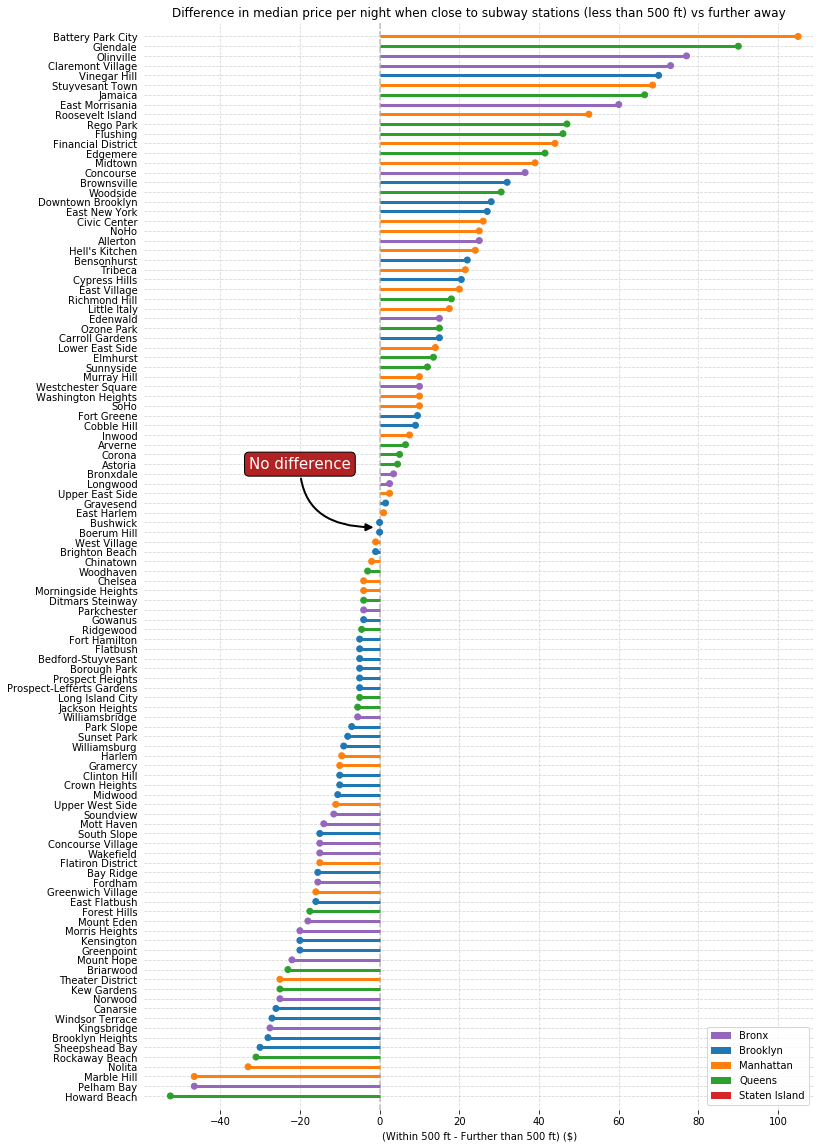

In [73]:
fig = plt.figure(figsize=(12,20))
ax = fig.add_subplot(111)
# Define colours for each neighbourhood_group
colors = {'Bronx':'#9467bd', 
          'Brooklyn':'#1f77b4', 
          'Manhattan':'#ff7f0e', 
          'Queens':'#2ca02c', 
          'Staten Island':'#d62728'}

# Get a list of colours which we can use in the plot
col_fn = sorted_data['neighbourhood_group_within'].apply(lambda x: colors[x])

# Define custom legend elements
legend_elements = [Patch(facecolor = '#9467bd', label = 'Bronx'),
                Patch(facecolor = '#1f77b4', label = 'Brooklyn'),
                Patch(facecolor = '#ff7f0e', label = 'Manhattan'),
                Patch(facecolor = '#2ca02c', label = 'Queens'),
                Patch(facecolor = '#d62728', label = 'Staten Island')]

# Plot vertical line at x = 0 to aid visualisation
ax = plt.axvline(x = 0, color='black', linestyle='--', alpha = 0.25, zorder = 1)
ax = plt.hlines(y = sorted_data.neighbourhood, xmin = 0, xmax = sorted_data.within_minus_outside_median, alpha = 1, color = col_fn, linewidth = 3, zorder = 2)
ax = plt.scatter(x = sorted_data.within_minus_outside_median, y = sorted_data.neighbourhood, color = col_fn, alpha = 1, zorder = 3)

plt.yticks(sorted_data.neighbourhood)

ax = plt.gca()
ax.set_xlim(-59, 109)
ax.margins(y = 0.01)
ax.yaxis.set_ticks_position('none') 

ax.grid(which='major', axis='both', linestyle='--', alpha = 0.5)
plt.gca().spines["top"].set_visible(False)    
plt.gca().spines["bottom"].set_visible(False)    
plt.gca().spines["right"].set_visible(False)    
plt.gca().spines["left"].set_visible(False) 


plt.annotate('No difference', xy = (-1, 58.5), xytext = (-20, 65), xycoords='data', 
            fontsize= 15, ha='center', va = 'center',
            bbox=dict(boxstyle='round', fc='firebrick'),
            arrowprops = dict(arrowstyle='-|>, head_length = 0.4, head_width = 0.2', lw=2.0, color='black', connectionstyle = 'angle3'), color='white')

ax.legend(handles = legend_elements, loc = 4)
ax.set_title('Difference in median price per night when close to subway stations (less than 500 ft) vs further away')
ax.set_xlabel('(Within 500 ft - Further than 500 ft) ($)', alpha=1);

This shows there is more nuance than the summary stats above suggest. Some neighbourhoods charge far higher rates when close to subway stations (e.g. Battery Park City) whilst others charge *less* when closer to stations (e.g. Howard beach). Perhaps people who visit these different areas have different priorities?

It's important to also keep in mind that we're still faced with the same problem as the last time we plotted data on a neighbourhood by neighbourhood basis. Namely, too few data points to draw reliable conclusions (e.g. 1 data point for Battery park City). Let's set a threshold where we have 20 data points for each neighbourhood: 10 properties within 500 ft and 10 properties further than 500 ft away:

In [74]:
threshold_sorted_data = sorted_data[(sorted_data.price_count_within >= 10) & (sorted_data.price_count_outside >= 10)]

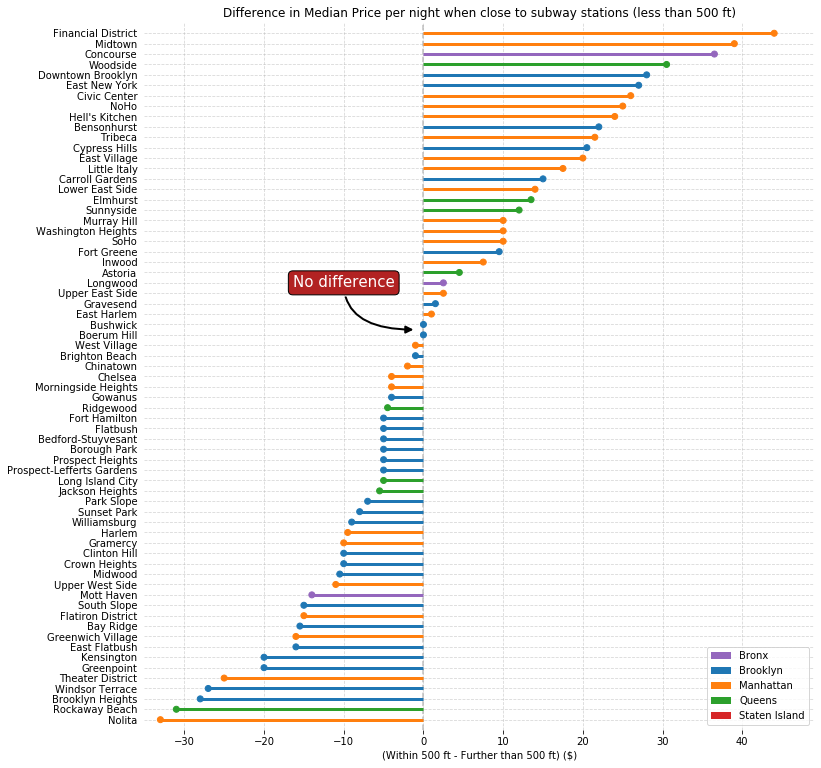

In [75]:
fig = plt.figure(figsize=(12,13))
ax = fig.add_subplot(111)
# Define colours for each neighbourhood_group
colors = {'Bronx':'#9467bd', 
          'Brooklyn':'#1f77b4', 
          'Manhattan':'#ff7f0e', 
          'Queens':'#2ca02c', 
          'Staten Island':'#d62728'}

# Get a list of colours which we can use in the plot
col_fn = threshold_sorted_data['neighbourhood_group_within'].apply(lambda x: colors[x])

# Define custom legend elements
legend_elements = [Patch(facecolor = '#9467bd', label = 'Bronx'),
                Patch(facecolor = '#1f77b4', label = 'Brooklyn'),
                Patch(facecolor = '#ff7f0e', label = 'Manhattan'),
                Patch(facecolor = '#2ca02c', label = 'Queens'),
                Patch(facecolor = '#d62728', label = 'Staten Island')]

ax = plt.axvline(x = 0, color='black', linestyle='--', alpha = 0.25, zorder = 1)
ax = plt.hlines(y = threshold_sorted_data.neighbourhood, xmin = 0, xmax = threshold_sorted_data.within_minus_outside_median, alpha = 1, color = col_fn, linewidth = 3, zorder = 2)
ax = plt.scatter(x = threshold_sorted_data.within_minus_outside_median, y = threshold_sorted_data.neighbourhood, color = col_fn, alpha = 1, zorder = 3)

plt.yticks(threshold_sorted_data.neighbourhood)

ax = plt.gca()
ax.set_xlim(-35, 49)
ax.margins(y = 0.01)
ax.yaxis.set_ticks_position('none') 

ax.grid(which='major', axis='both', linestyle='--', alpha = 0.5)
plt.gca().spines["top"].set_visible(False)    
plt.gca().spines["bottom"].set_visible(False)    
plt.gca().spines["right"].set_visible(False)    
plt.gca().spines["left"].set_visible(False) 

plt.annotate('No difference', xy = (-1, 37.5), xytext = (-10, 42), xycoords='data', 
            fontsize= 15, ha='center', va = 'center',
            bbox=dict(boxstyle='round', fc='firebrick'),
            arrowprops = dict(arrowstyle='-|>, head_length = 0.4, head_width = 0.2', lw=2.0, color='black', connectionstyle = 'angle3'), color='white')

ax.legend(handles = legend_elements, loc = 4)
ax.set_title('Difference in Median Price per night when close to subway stations (less than 500 ft)')
ax.set_xlabel('(Within 500 ft - Further than 500 ft) ($)');

Some observations:
* We seem to lose data for many neighbourhoods, particularly those in the Bronx and Queens which suggests there's very few listings in these places. 
* There's no data for Staten Island (this is true before we threshold the data too) but that isn't surprising since Staten Island does not have any subway stations! 
* A lot of neighbourhoods in Manhattan charge more for being closer to the subway. This includes the Financial District; maybe quick access to the subway is important for financial-type people!
* Nolita residents charge much less per night for being closer to subway stations. If I'm visiting New York and want to stay in Manhattan, this might be a good choice for me! Although I should probably keep in mind that the median price is still quite high relative to other areas in Manhattan:

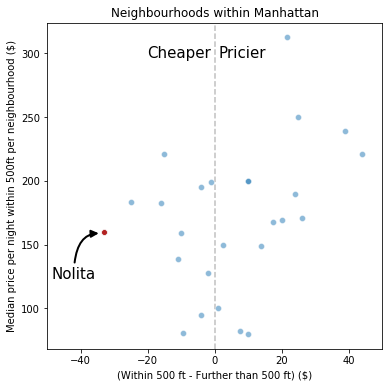

In [76]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

ax = plt.axvline(x = 0, color = 'black', linestyle = '--', alpha = 0.25, zorder = 1)
ax = sns.scatterplot(data = threshold_sorted_data[threshold_sorted_data.neighbourhood_group_within == 'Manhattan'], x = 'within_minus_outside_median', y = 'price_median_within', alpha = 0.5, zorder = 2)
ax = sns.scatterplot(data = threshold_sorted_data[threshold_sorted_data.neighbourhood == 'Nolita'], x = 'within_minus_outside_median', y = 'price_median_within', color = 'firebrick', zorder = 3)

# 'Before' and 'After' Annotations
ax.text(-1.15,300, 'Cheaper', horizontalalignment = 'right', verticalalignment = 'center', fontdict = {'size':15})
ax.text(1.15, 300, 'Pricier', horizontalalignment = 'left', verticalalignment = 'center', fontdict = {'size':15})

plt.annotate('Nolita', xy = (-34, 159), xytext = (-42, 127), xycoords='data', 
            fontsize= 15, ha='center', va = 'center',
            arrowprops = dict(arrowstyle='-|>, head_length = 0.4, head_width = 0.2', lw=2.0, color='black', connectionstyle = 'angle3'), color='black')

ax.set_xlim(-50,50)
ax.set_title('Neighbourhoods within Manhattan')
ax.set_ylabel('Median price per night within 500ft per neighbourhood ($)')
ax.set_xlabel('(Within 500 ft - Further than 500 ft) ($)');

## Are AirBNBs over represented in different neighbourhoods?

From looking at the per neighbourhood data above it seems there are very few listings advertised in some neighbourhoods. I wonder if some neighbourhoods have more listings than they 'should': i.e. is the ratio of listings : population similiar (or not) for all neighbourhoods?

Unfortunately, the latest population data I could get for [NYC neighbourhoods was from 2010](https://data.cityofnewyork.us/City-Government/New-York-City-Population-By-Neighborhood-Tabulatio/swpk-hqdp). [Recent estimates](https://www1.nyc.gov/site/planning/planning-level/nyc-population/current-future-populations.page) for 2018 suggest that population levels have increased across all five boroughs (by
approximately 0.4 %). Therefore for the purposes of this analysis, we’ll assume population levels have not changed since the 2010 data was released.
Re-evaluation will be required as new neighborhood-level data becomes available.

In [77]:
# Import neighbourhood populations (https://data.cityofnewyork.us/City-Government/New-York-City-Population-By-Neighborhood-Tabulatio/swpk-hqdp) and clean data
neighbourhood_pops = pd.read_csv('./data/population_by_neighbourhood.csv')
neighbourhood_pops.rename(columns = {'NTA Name' : 'neighbourhood', 'NTA Code' : 'ntacode'}, inplace = True)

neighbourhood_pops = neighbourhood_pops[neighbourhood_pops.Year == 2010]
neighbourhood_pops

Borough  Year  FIPS County Code ntacode  \
195          Bronx  2010                 5    BX01   
196          Bronx  2010                 5    BX03   
197          Bronx  2010                 5    BX05   
198          Bronx  2010                 5    BX06   
199          Bronx  2010                 5    BX07   
..             ...   ...               ...     ...   
385  Staten Island  2010                85    SI37   
386  Staten Island  2010                85    SI45   
387  Staten Island  2010                85    SI48   
388  Staten Island  2010                85    SI54   
389  Staten Island  2010                85    SI99   

                       neighbourhood  Population  
195               Claremont-Bathgate       31078  
196  Eastchester-Edenwald-Baychester       34517  
197       Bedford Park-Fordham North       54415  
198                          Belmont       27378  
199                        Bronxdale       35538  
..                               ...         ...  
385               Stapleton-Rosebank       26453  
386           New Dorp-Midland Beach       21896  
387                    Arden Heights       25238  
388                      Great Kills       40720  
389  park-cemetery-etc-Staten Island           0  

[195 rows x 6 columns]

To answer this question, we'll first want to get the number of AirBNB listings in each neighbourhood and the population in each neighbourhood. However after looking at these new population data, one problem is immediately apparent. The neighbourhoods do not match up with the AirBNB listings, which means we can't merge our two dataframes straight away:

In [78]:
# Get unique values in the neighbourhood column for Airbnb df
A = df.neighbourhood.unique()
# Get unique values in the neighbourhood column for population df
B = neighbourhood_pops.neighbourhood.unique()

print(f'There are {len(A)} neighbourhoods in our AirBNB dataframe. {len([i for i in A if i not in B])} of these neighbourhoods are not found in the population-information dataframe.')

There are 221 neighbourhoods in our AirBNB dataframe. 153 of these neighbourhoods are not found in the population-information dataframe.


Though thankfully our population dataframe and our neighbourhood boundaries dataframe do have an NTA code column which is unique to each neighbourhood (bear with me). If we check these values, there aren't any missing points:

In [79]:
# Get unique values in the ntacode column for population df
C = neighbourhood_pops.ntacode.unique()
# Get unique values in the ntacode column for boundaries df
D = neighbourhood_boundaries.ntacode.unique()

print(f' All neighbourhoods in the population dataframe can be matched with our boundaries dataframe on NTA code: {len([i for i in C if i not in D])}')

 All neighbourhoods in the population dataframe can be matched with our boundaries dataframe on NTA code: 0


What we can now do is merge these two dataframes on the NTA code. This will allow us to eventually take advantage of `shapely`/`geopandas` to perform a spatial join with our AirBNB listings dataframe and find AirBNBs within the defined neighbourhood boundaries:

In [80]:
# Merge the two dataframes
neighbourhood_pops_boundaries = pd.merge(neighbourhood_boundaries, neighbourhood_pops, on = 'ntacode')

# Rename and drop columns that aren't necessary
neighbourhood_pops_boundaries.rename(columns = {'neighbourhood_x' : 'neighbourhood', 'NTA Code' : 'ntacode', 'Population' : 'population'}, inplace = True)

# Drop unnecessary columns.
neighbourhood_pops_boundaries = neighbourhood_pops_boundaries.drop(['neighbourhood_y','Borough','FIPS County Code','Year'], axis = 1)

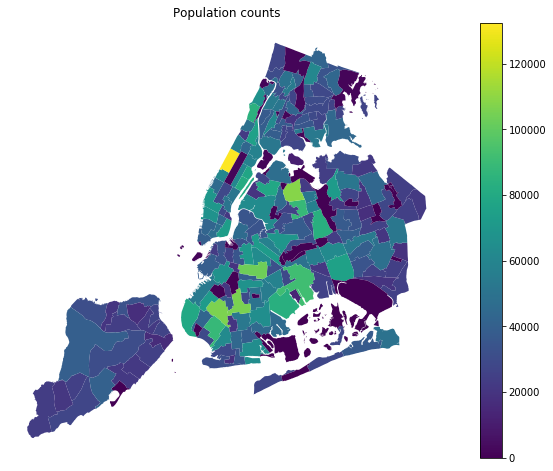

In [81]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

pop_plot = neighbourhood_pops_boundaries.plot(ax = ax, column = 'population', cmap = 'viridis', legend = True)

ax.axis('off')
ax.set_title('Population counts');

In [82]:
neighbourhood_pops_boundaries.head()

neighbourhood_group ntacode   neighbourhood  shape_area  shape_leng  \
0            Brooklyn    BK88    Borough Park 54005018.75    39247.23   
1              Queens    QN51     Murray Hill 52488276.48    33266.90   
2              Queens    QN27   East Elmhurst 19726845.26    19816.71   
3              Queens    QN07          Hollis 22887772.77    20976.34   
4           Manhattan    MN06  Manhattanville 10647077.61    17040.69   

                                            geometry  population  
0  POLYGON ((990897.900024416 169268.1207885206, ...      106357  
1  POLYGON ((1038593.459228517 221913.3550414529,...       51739  
2  POLYGON ((1022728.274841309 217530.8082274867,...       23150  
3  POLYGON ((1051539.66003418 201007.0130004398, ...       20269  
4  POLYGON ((999174.2608032241 238490.1047973094,...       22950

So now we have a dataframe which has two key pieces of information: the neighbourhood geometry and population counts. 

Now we need to get the number of AirBNB listings for each neighbourhood and combine that with the `neighbourhood_pops_boundaries` dataframe. Let's begin by performing a spatial join between our AirBNB dataframe, `geo_df` and `neighbourhood_pops_boundaries`:

In [83]:
# Join dataframes
merged_df = gpd.sjoin(geo_df, 
                     neighbourhood_pops_boundaries,
                     how = 'right',
                     op = 'intersects',
                     lsuffix = 'air_df',
                     rsuffix = 'pop_df'
                    )
# Reset index
merged_df = merged_df.reset_index()

# Drop a whole bunch of columns we're not wanting (after typing this I realise it might have been quicker to subset :) )
merged_df = merged_df.drop(['index_pop_df',
                            'index_air_df',
                            'host_id',
                            'host_name',
                            'id',
                            'x',
                            'y',
                            'z',
                            'latitude',
                            'longitude',
                            'neighbourhood_group_y',
                            'minimum_nights',
                            'availability_365',
                            'more_than_1_listing',
                            'number_of_reviews',
                            'reviews_per_month',
                            'last_review',
                            'calculated_host_listings_count',
                            'name'], axis = 1)

# Rename columns for clarity.
merged_df = merged_df.rename(columns = {'neighbourhood_group_x' : 'neighbourhood_group_air_df',  'neighbourhood_x' : 'neighbourhood_air_df', 'neighbourhood_y' : 'neighbourhood_pop_df'})

merged_df.sample(5, random_state = 1234)

neighbourhood_group_air_df neighbourhood_air_df        room_type  price  \
33620                   Brooklyn     Brooklyn Heights  Entire home/apt 103.00   
19412                  Manhattan         East Village  Entire home/apt 300.00   
12952                   Brooklyn         Williamsburg     Private room  70.00   
15789                   Brooklyn        Crown Heights     Private room  65.00   
5100                   Manhattan       Hell's Kitchen  Entire home/apt 200.00   

      days_since     cut_days ntacode          neighbourhood_pop_df  \
33620   555 days   1+ year(s)    BK09  Brooklyn Heights-Cobble Hill   
19412   797 days   1+ year(s)    MN22                  East Village   
12952   143 days  3-12 months    BK73         North Side-South Side   
15789        NaT          NaN    BK61           Crown Heights North   
5100      5 days     < 1 week    MN15                       Clinton   

       shape_area  shape_leng  \
33620  9983620.16    14264.79   
19412 10894316.34    13555.24   
12952 28869767.89    28149.98   
15789 51619074.19    35635.54   
5100  18362149.83    34481.63   

                                                geometry  population  
33620  POLYGON ((986367.7355957018 190549.239196723, ...       22887  
19412  POLYGON ((989084.5311889673 205727.6301879414,...       44136  
12952  POLYGON ((995851.9155883808 203199.3317870576,...       45774  
15789  POLYGON ((1005982.533996582 186616.9805907705,...      103169  
5100   POLYGON ((985958.6517944358 220876.7498168417,...       45884

Now for each listing we have an associated population, geom and ntacode (this becomes important in a second). 

Let's perform some summary statistics to get the number of listings in each neighbourhood. We'll group by neighbourhood as defined in `geo_df` (`neighbourhood_air_df`), neighbourhood as defined in `neighbourhood_pops_boundaries` (`neighbourhood_pop_df`) and `ntacode` (this is only present in the latter dataframe), and then find the mean and count for the population column. 

In this context the 'mean' population is the same as the population for the respective neighbourhood. This works because the population column returns the same value for each neighbourhood. For example if the population of a neighbourhood was 10, and there were 2 properties which were listed in that neighbourhood, then the mean would be $\frac{10 + 10}{2} = 10$. If there was 4 listings/rows with this neighbourhood, then the 'mean' would be $\frac{10 + 10 + 10 + 10}{4} = 10$. The returned count is simply the number of AirBNB listings in that neighbourhood.

In [84]:
merged_df_stats = merged_df.loc[:,('population', 'neighbourhood_air_df','neighbourhood_pop_df', 'neighbourhood_group_air_df','ntacode')].groupby(['neighbourhood_air_df','neighbourhood_pop_df','neighbourhood_group_air_df','ntacode']).agg(['mean','count'])

# Rename columns
merged_df_stats.columns = ['_'.join(col).rstrip('_') for col in merged_df_stats.columns.values]

# Sort by median price and take top 50
merged_df_stats = merged_df_stats.reset_index()

merged_df_stats

neighbourhood_air_df                        neighbourhood_pop_df  \
0               Allerton                     Allerton-Pelham Gardens   
1               Allerton                                   Bronxdale   
2               Allerton                              Pelham Parkway   
3          Arden Heights  Annadale-Huguenot-Prince's Bay-Eltingville   
4          Arden Heights                               Arden Heights   
..                   ...                                         ...   
486             Woodlawn                     park-cemetery-etc-Bronx   
487              Woodrow                           Rossville-Woodrow   
488             Woodside                            Elmhurst-Maspeth   
489             Woodside        Hunters Point-Sunnyside-West Maspeth   
490             Woodside                                    Woodside   

    neighbourhood_group_air_df ntacode  population_mean  population_count  
0                        Bronx    BX31            28903                22  
1                        Bronx    BX07            35538                19  
2                        Bronx    BX49            30073                 1  
3                Staten Island    SI01            27770                 2  
4                Staten Island    SI48            25238                 2  
..                         ...     ...              ...               ...  
486                      Bronx    BX99             1906                 1  
487              Staten Island    SI32            20763                 1  
488                     Queens    QN50            25521                33  
489                     Queens    QN31            63271                 8  
490                     Queens    QN63            45099               194  

[491 rows x 6 columns]

Unfortunately when performing the summary statistics it's not possible to retain the geometry (as far as I know), so we have to perform *another* merge to get that information back.

In [85]:
# Merge the above dataframe with neighbourhood_boundaries on ntacode to get geometry/area back
merged_df_stats = pd.merge(merged_df_stats, 
                           neighbourhood_boundaries[['ntacode','geometry','shape_area']], 
                           on = 'ntacode',
                           how = 'left',
                           suffixes = ('','_boundaries'))

merged_df_stats.head()

neighbourhood_air_df                        neighbourhood_pop_df  \
0             Allerton                     Allerton-Pelham Gardens   
1             Allerton                                   Bronxdale   
2             Allerton                              Pelham Parkway   
3        Arden Heights  Annadale-Huguenot-Prince's Bay-Eltingville   
4        Arden Heights                               Arden Heights   

  neighbourhood_group_air_df ntacode  population_mean  population_count  \
0                      Bronx    BX31            28903                22   
1                      Bronx    BX07            35538                19   
2                      Bronx    BX49            30073                 1   
3              Staten Island    SI01            27770                 2   
4              Staten Island    SI48            25238                 2   

                                            geometry   shape_area  
0  POLYGON ((1026308.769592287 256767.6973876441,...  31693044.31  
1  POLYGON ((1022588.078796388 256759.4393920354,...  15185447.54  
2  POLYGON ((1029390.141601565 251648.6525878384,...  23032576.37  
3  POLYGON ((937062.4696044936 143742.5911864678,... 141057788.30  
4  POLYGON ((936499.8807983419 143900.5311889182,...  50410816.25

If you look at the dataset above, we can see that in the AirBNB dataset there are multiple entries for the same neighbourhood. For instance, rows 1 through 3 are listed as 'Allerton' by AirBNB (`neighbourhood_air_df` column) but as different neighbourhoods (Allerton-Pelham Gardens, Bronxdale, Pelham Parkway) by the data we got from the NYC government website (`neighbourhood_pop_df`).

Unfortunately, there is another (sort-of-related) problem. In the `neighbourhood_boundaries` dataframes there are catch-alls like 'park-cemetery-etc-Brokyln' which describe very large non-contiguous areas distributed throughout NYC. Occasionally the provided location for an AirBNB will fall just inside these boundaries when the AirBNB is probably in a neighbourhood just next to a park/cemetery. This means that the 'park-cemetery-etc...' values are repeated many times for different neighbourhoods (because this category is distributed throughout NYC) which artificially inflates the population/area values.

The below figure shows one such example. From looking at several of these neighbourhoods, it seems that AirBNB (or at least the original AirBNB dataset) clusters geographically close neighbourhoods together into one region. I don't know why but I'd guess this is because it helps people find AirBNBs that are close to the specific region they search for. Perhaps colloquially a certain name for a neighbourhood covers a larger area than what the NYC government considers a neighbourhood?

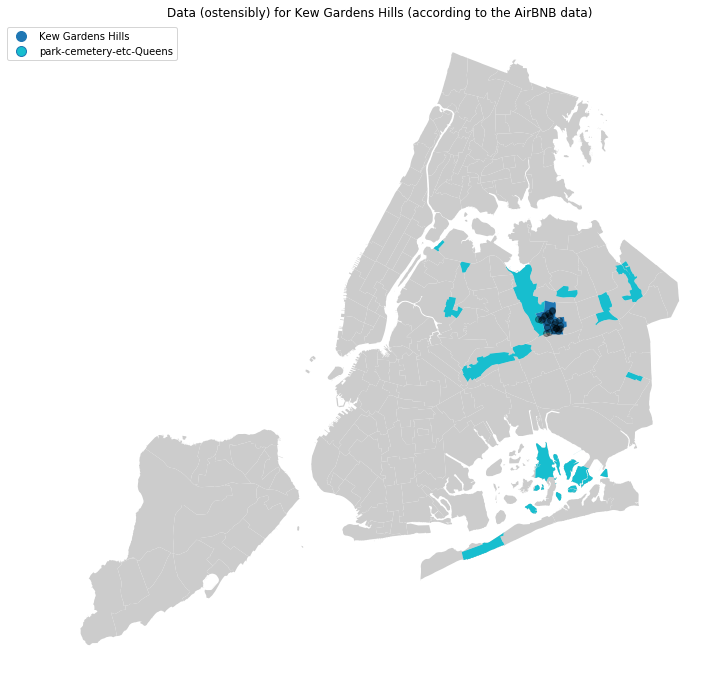

In [86]:
# Find neighbourhoods which are repeated
dup_list = merged_df_stats['neighbourhood_air_df'][merged_df_stats.duplicated(subset = 'neighbourhood_air_df', keep = 'last')].drop_duplicates()

# Pick a neighbourhood
rand_area = str(dup_list.sample(random_state = 1234).iloc[0])

# Convert back to geodataframe
geo_merged_stats = gpd.GeoDataFrame(merged_df_stats, geometry = merged_df_stats.geometry)
geo_merged_stats.crs = {'init': 'epsg:2263'}

# Plot neighbourhood data...
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
base_plot = neighbourhood_boundaries.plot(ax = ax, color = "#CCCCCC")
geo_merged_stats[geo_merged_stats.neighbourhood_air_df == rand_area].plot(column = 'neighbourhood_pop_df', ax = ax, legend = True)
geo_df[geo_df.neighbourhood == rand_area].plot(ax = ax, color = '#000000', alpha = 0.3, zorder = 3)
ax.axis('off')
leg = ax.get_legend()
leg.set_bbox_to_anchor((0., 0.8, 0.2, 0.2))

ax.set_title(f'Data (ostensibly) for {rand_area} (according to the AirBNB data)');

Since we're interested in the data from the perspective of AirBNB and not how the NYC government classifies areas, I'm going to cluster the data based on AirBNB's definition of neighbourhoods. I'm also going to remove rows which fall into the miscellaneous 'park-cemetery...' category. There's actually very few listings (106 of ~48k) which fall into these categories (as you might expect - they're graveyards), so it shouldn't have too much impact on our interpretation.

In [87]:
# Remove rows where listings are assigned to the park-cemetery-etc category or known non-residential areas.
geo_merged_stats = geo_merged_stats[~geo_merged_stats.neighbourhood_pop_df.str.contains("park-cemetery-etc|Navy Yard")]

# Aggregate based on AirBNB neighbourhoods and take sum of numeric columns. This will combine polygon geometries together too.
geo_merged_stats = geo_merged_stats.dissolve(by = ['neighbourhood_air_df','neighbourhood_group_air_df'], aggfunc = 'sum').reset_index()

In [88]:
# Find density of AirBNBs per 100k population 
geo_merged_stats['density_per_100k'] = 100000 * geo_merged_stats.population_count / geo_merged_stats.population_mean
# Log2 of the ratio
geo_merged_stats['density_per_100k_log2'] = np.log2(100000 * geo_merged_stats.population_count / geo_merged_stats.population_mean)

In [89]:
geo_merged_stats.sort_values('density_per_100k', ascending = False).head()

neighbourhood_air_df neighbourhood_group_air_df  \
207         West Village                  Manhattan   
212         Williamsburg                   Brooklyn   
33               Chelsea                  Manhattan   
94        Hell's Kitchen                  Manhattan   
189     Theater District                  Manhattan   

                                              geometry  population_mean  \
207  POLYGON ((987048.2695922866 206851.146789499, ...            66880   
212  POLYGON ((999792.1503906251 193662.2709960385,...           347529   
33   POLYGON ((983825.3027954124 217128.7291869566,...            98780   
94   POLYGON ((986568.1843872084 214236.8384398846,...           177523   
189  POLYGON ((991725.24420166 217725.299194284, 99...            28630   

     population_count   shape_area  density_per_100k  density_per_100k_log2  
207               768  24970650.30           1148.33                  10.17  
212              3919 212641713.91           1127.68                  10.14  
33               1112  67259916.27           1125.73                  10.14  
94               1958  71236118.47           1102.96                  10.11  
189               288  30191534.22           1005.94                   9.97

In [90]:
geo_merged_stats['pop_density'] = geo_merged_stats.population_mean / (geo_merged_stats.shape_area / 5280)
geo_merged_stats

neighbourhood_air_df neighbourhood_group_air_df  \
0               Allerton                      Bronx   
1          Arden Heights              Staten Island   
2               Arrochar              Staten Island   
3                Arverne                     Queens   
4                Astoria                     Queens   
..                   ...                        ...   
214      Windsor Terrace                   Brooklyn   
215            Woodhaven                     Queens   
216             Woodlawn                      Bronx   
217              Woodrow              Staten Island   
218             Woodside                     Queens   

                                              geometry  population_mean  \
0    POLYGON ((1029390.141601565 251648.6525878384,...            94514   
1    POLYGON ((937062.4696044936 143742.5911864678,...            53008   
2    POLYGON ((966187.48199463 153868.426025336, 96...            40914   
3    POLYGON ((1048650.082397458 157173.0571898913,...            36885   
4    POLYGON ((1012323.99499512 216152.6744384239, ...           219270   
..                                                 ...              ...   
214  POLYGON ((989751.2355957056 180153.4827880264,...            20988   
215  POLYGON ((1026082.093994143 193715.7125853895,...            56674   
216  POLYGON ((1029210.338623048 265000.6362304162,...            42483   
217  POLYGON ((927799.3171997046 141930.2536010162,...            20763   
218  POLYGON ((1004855.955993649 213309.3013915424,...           133891   

     population_count   shape_area  density_per_100k  density_per_100k_log2  \
0                  42  69911068.21             44.44                   5.47   
1                   4 191468604.54              7.55                   2.92   
2                  21 107935158.86             51.33                   5.68   
3                  77  61894959.37            208.76                   7.71   
4                 900 164244822.76            410.45                   8.68   
..                ...          ...               ...                    ...   
214               157  14041668.19            748.05                   9.55   
215                87  37000431.87            153.51                   7.26   
216                 9  39738785.99             21.18                   4.40   
217                 1  64963357.57              4.82                   2.27   
218               235 152597699.10            175.52                   7.46   

     pop_density  
0           7.14  
1           1.46  
2           2.00  
3           3.15  
4           7.05  
..           ...  
214         7.89  
215         8.09  
216         5.64  
217         1.69  
218         4.63  

[219 rows x 9 columns]

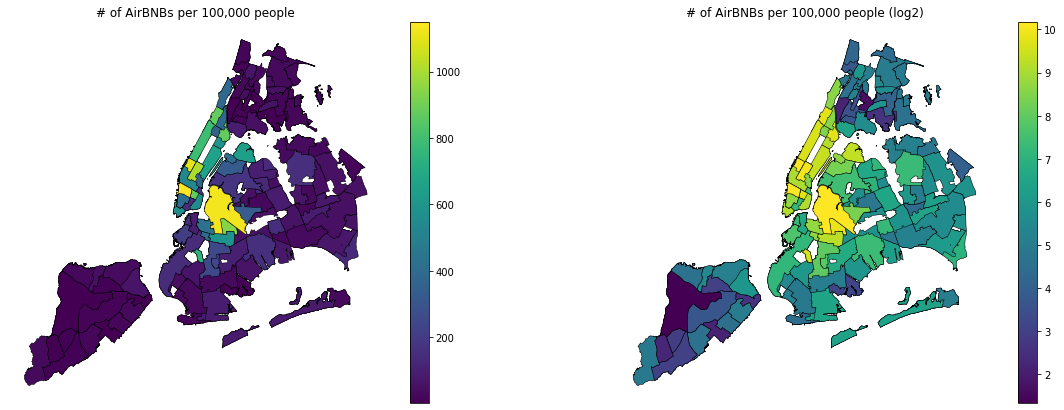

In [91]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey = True, sharex = True, figsize = (20,7))

base_plot = geo_merged_stats.plot(ax = ax1, color = "#CCCCCC")
geo_merged_stats.plot(ax = ax1, markersize = 12, column = 'density_per_100k', cmap = 'viridis', edgecolor = "#000000", linewidth = 0.5, legend = True)

base_plot = geo_merged_stats.plot(ax = ax2, color = "#CCCCCC")
geo_merged_stats.plot(ax = ax2, markersize = 12, column = 'density_per_100k_log2', cmap = 'viridis', edgecolor = "#000000", linewidth = 0.5, legend = True)

ax1.set_title('# of AirBNBs per 100,000 people');
ax2.set_title('# of AirBNBs per 100,000 people (log2)')

ax1.axis('off')
ax2.axis('off');

So these graphs show that AirBNBs are more concentrated toward Manhattan and Broolyn.

Let's now normalize the data relative to the mean:

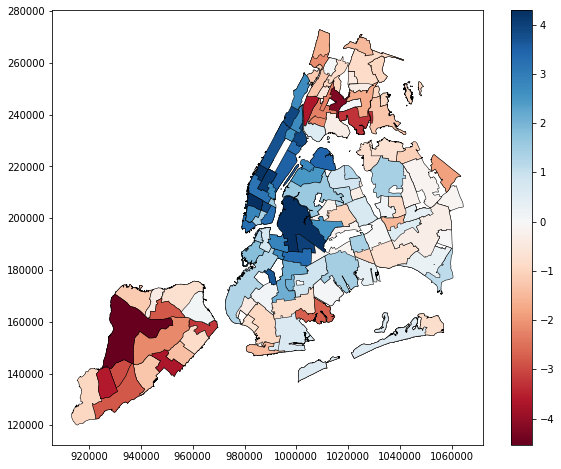

In [92]:
# Get mean ratio
mean_ratio = geo_merged_stats.density_per_100k_log2.mean()

# Find how much each row diverges from mean
geo_merged_stats['from_mean'] = geo_merged_stats['density_per_100k_log2'] - mean_ratio
geo_merged_stats.sort_values('density_per_100k', ascending = True)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

# normalize color
v_min, v_max, v_center = geo_merged_stats.from_mean.min(), geo_merged_stats.from_mean.max(), 0
divnorm = mcolors.DivergingNorm(vmin = v_min, vcenter = v_center, vmax = v_max)

# create a normalized colorbar
cbar = plt.cm.ScalarMappable(norm = divnorm, cmap='RdBu')

base_plot = geo_merged_stats.plot(ax = ax, color = "#CCCCCC")
geo_merged_stats.plot(ax = ax, markersize = 12, column = 'from_mean', edgecolor = "#000000", linewidth = 0.5, cmap='RdBu', legend=False, norm=divnorm)

fig.colorbar(cbar, ax=ax);

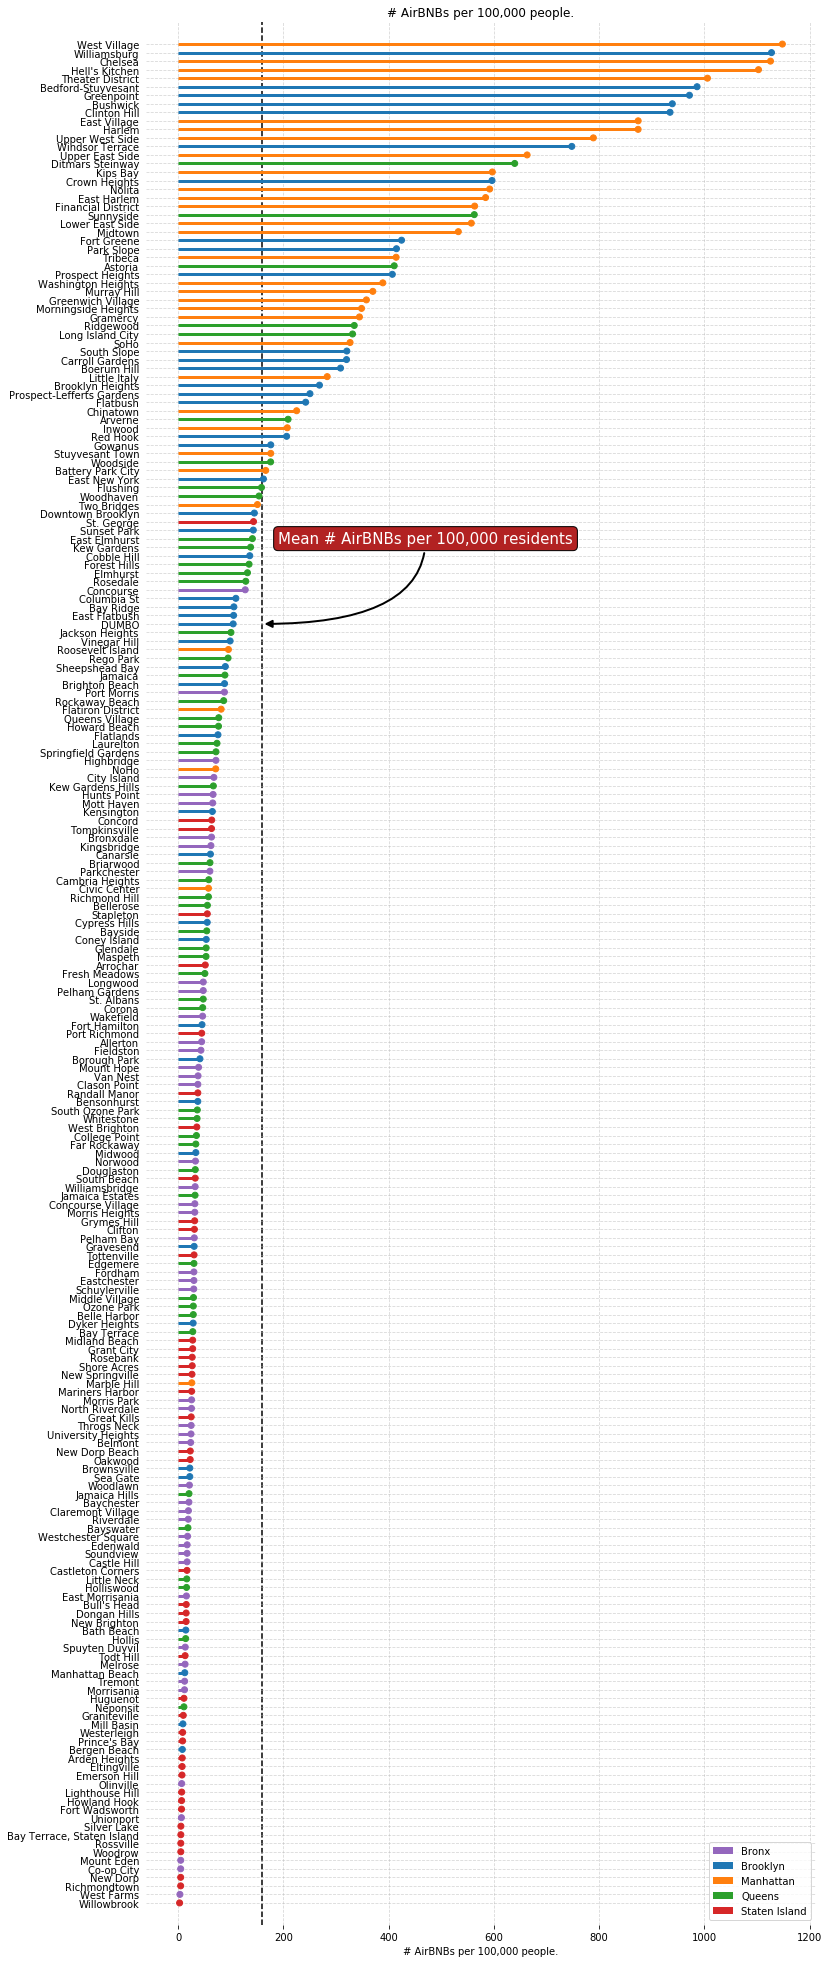

In [93]:
# Arrange by desceding ratios
geo_merged_stats = geo_merged_stats.sort_values('density_per_100k', ascending = True)
mean_ratio = geo_merged_stats.density_per_100k.mean()

# Define colours for each neighbourhood_group
colors = {'Bronx':'#9467bd', 
          'Brooklyn':'#1f77b4', 
          'Manhattan':'#ff7f0e', 
          'Queens':'#2ca02c', 
          'Staten Island':'#d62728'}

# Trying to do conditional alpha, not working.... returns TypeError: alpha must be a float or None when trying to plot
def alpha_f(x):
    if x['density_per_100k'] > mean_ratio:
        return 1
    else:
        return 0.5
#geo_merged_stats['alpha_fn'] = geo_merged_stats.apply(alpha_f, axis = 1)
#geo_merged_stats['alpha'] = [0.5 if x < mean_ratio else 1 for x in geo_merged_stats['density_per_100k']]

# Get a list of colours which we can use in the plot
col_fn = geo_merged_stats['neighbourhood_group_air_df'].apply(lambda x: colors[x])

# Define custom legend elements
legend_elements = [Patch(facecolor = '#9467bd', label = 'Bronx'),
                Patch(facecolor = '#1f77b4', label = 'Brooklyn'),
                Patch(facecolor = '#ff7f0e', label = 'Manhattan'),
                Patch(facecolor = '#2ca02c', label = 'Queens'),
                Patch(facecolor = '#d62728', label = 'Staten Island')]

fig = plt.figure(figsize=(12,35))
ax = fig.add_subplot(111)

ax = plt.axvline(x = mean_ratio, color='black', linestyle='--', alpha = 1, zorder = 1)
ax = plt.hlines(y = geo_merged_stats.neighbourhood_air_df, xmin = 0, xmax = geo_merged_stats.density_per_100k, color = col_fn, alpha = 1, linewidth = 3, zorder = 2)
ax = plt.scatter(x = geo_merged_stats.density_per_100k, y = geo_merged_stats.neighbourhood_air_df, color = col_fn, alpha = 1, zorder = 3)

plt.yticks(geo_merged_stats.neighbourhood_air_df)

plt.annotate('Mean # AirBNBs per 100,000 residents', xy = (160, 150), xytext = (470, 160), xycoords='data', 
            fontsize= 15, ha='center', va = 'center',
            bbox=dict(boxstyle='round', fc='firebrick'),
            arrowprops = dict(arrowstyle='-|>, head_length = 0.4, head_width = 0.2', lw=2.0, color='black', connectionstyle = 'angle3'), color='white')

ax = plt.gca()
ax.margins(y = 0.01)
ax.yaxis.set_ticks_position('none') 

ax.grid(which='major', axis='both', linestyle='--', alpha = 0.5)
plt.gca().spines["top"].set_visible(False)    
plt.gca().spines["bottom"].set_visible(False)    
plt.gca().spines["right"].set_visible(False)    
plt.gca().spines["left"].set_visible(False) 

ax.legend(handles = legend_elements, loc = 4);
ax.set_title('# AirBNBs per 100,000 people.')
ax.set_xlabel('# AirBNBs per 100,000 people.');

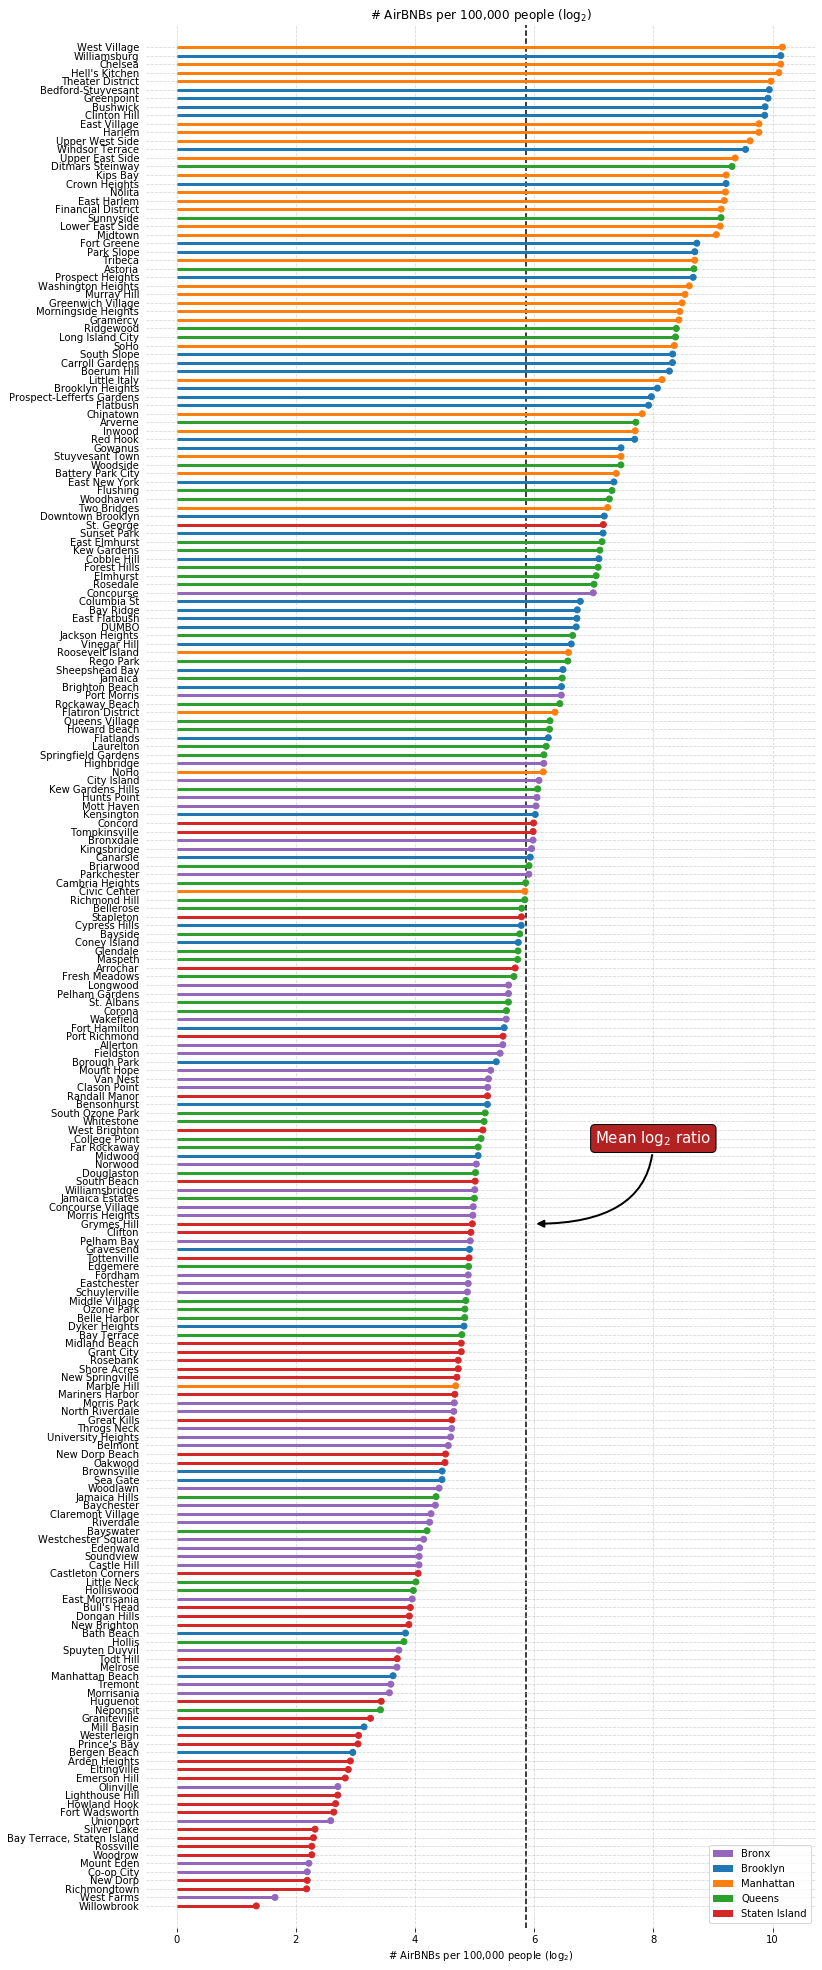

In [94]:
# Arrange by desceding ratios
geo_merged_stats = geo_merged_stats.sort_values('density_per_100k_log2', ascending = True)
mean_ratio = geo_merged_stats.density_per_100k_log2.mean()

# Define colours for each neighbourhood_group
colors = {'Bronx':'#9467bd', 
          'Brooklyn':'#1f77b4', 
          'Manhattan':'#ff7f0e', 
          'Queens':'#2ca02c', 
          'Staten Island':'#d62728'}

# Trying to do conditional alpha, not working.... returns TypeError: alpha must be a float or None when trying to plot
def alpha_f(x):
    if x['density_per_100k'] > mean_ratio:
        return 1
    else:
        return 0.5
#geo_merged_stats['alpha_fn'] = geo_merged_stats.apply(alpha_f, axis = 1)
#geo_merged_stats['alpha'] = [0.5 if x < mean_ratio else 1 for x in geo_merged_stats['density_per_100k']]

# Get a list of colours which we can use in the plot
col_fn = geo_merged_stats['neighbourhood_group_air_df'].apply(lambda x: colors[x])

# Define custom legend elements
legend_elements = [Patch(facecolor = '#9467bd', label = 'Bronx'),
                Patch(facecolor = '#1f77b4', label = 'Brooklyn'),
                Patch(facecolor = '#ff7f0e', label = 'Manhattan'),
                Patch(facecolor = '#2ca02c', label = 'Queens'),
                Patch(facecolor = '#d62728', label = 'Staten Island')]

fig = plt.figure(figsize=(12,35))
ax = fig.add_subplot(111)

ax = plt.axvline(x = mean_ratio, color='black', linestyle='--', alpha = 1, zorder = 1)
ax = plt.hlines(y = geo_merged_stats.neighbourhood_air_df, xmin = 0, xmax = geo_merged_stats.density_per_100k_log2, color = col_fn, alpha = 1, linewidth = 3, zorder = 2)
ax = plt.scatter(x = geo_merged_stats.density_per_100k_log2, y = geo_merged_stats.neighbourhood_air_df, color = col_fn, alpha = 1, zorder = 3)

plt.yticks(geo_merged_stats.neighbourhood_air_df)

plt.annotate('Mean log$_2$ ratio', xy = (6, 80), xytext = (8, 90), xycoords='data', 
            fontsize= 15, ha='center', va = 'center',
            bbox=dict(boxstyle='round', fc='firebrick'),
            arrowprops = dict(arrowstyle='-|>, head_length = 0.4, head_width = 0.2', lw=2.0, color='black', connectionstyle = 'angle3'), color='white')

ax = plt.gca()
ax.margins(y = 0.01)
ax.yaxis.set_ticks_position('none') 

ax.grid(which='major', axis='both', linestyle='--', alpha = 0.5)
plt.gca().spines["top"].set_visible(False)    
plt.gca().spines["bottom"].set_visible(False)    
plt.gca().spines["right"].set_visible(False)    
plt.gca().spines["left"].set_visible(False) 

ax.legend(handles = legend_elements, loc = 4);
ax.set_title('# AirBNBs per 100,000 people (log$_2$)')
ax.set_xlabel('# AirBNBs per 100,000 people (log$_2$)');

So these data reveal a couple of interesting points. AirBNB listings are not distributed evenly across neighbourhoods. Instead they seem to be concentrated toward Manhattan and Brooklyn. This is also clearly reflected in the maps if we look at the boundaries between Manhattan and Bronx for instance. Staten Island and Queens almost exclusively occupy the bottom portion of these figures revealing very few AirBNBs are listed here. 

If we look at West Village, the area with the highest concentration of listings, what's remarkable is that nearly all the listings are from individual hosts. There are very few of the 'super' hosts I described earlier and of those who belong to this category, they only have a small minority (73 of 768 properties) of these listings!

In [95]:
geo_df[geo_df.calculated_host_listings_count >= 3][['id','neighbourhood']].groupby('neighbourhood').count().tail(8)

id
neighbourhood       
West Village      73
Whitestone         3
Williamsbridge    16
Williamsburg     365
Windsor Terrace   16
Woodhaven         42
Woodlawn           2
Woodside          87